In [3]:
# import package
import pandas as pd
import numpy as np

import requests
import bs4
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

import pymongo
from pymongo import MongoClient
from sklearn import preprocessing
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Data Scraping & Wragling

### Find Data for US Crude Oil

In [4]:
# scrape data from website
url = 'https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=W_EPC0_SAX_YCUOK_MBBL&f=W'
r = requests.get(url)

In [5]:
# turn into text
urlText = r.text

In [6]:
# turn text into soup
soup = bs4.BeautifulSoup(urlText)

In [7]:
# find table
cells = soup.find('table', attrs={'class': 'FloatTitle'}).find_all('td')
cells = [i.text.replace('\xa0', '') for i in cells]
# remove the empty line between each year
cells_clean = []
for i in range(len(cells)):
    if i + 1 < len(cells) and '-' in cells[i + 1] and cells[i + 1].split('-')[1] == 'Jan':
        continue
    else:
        cells_clean.append(cells[i])
# turn data into two-d array
two_d_arr = []
i = 0
arr = []
while i < len(cells_clean):
    if i % 11 == 0 and i != 0:
        two_d_arr.append(arr)
        arr = []
        arr.append(cells_clean[i])
        i += 1
    elif i == len(cells_clean) - 1:
        arr.append(cells_clean[i])
        two_d_arr.append(arr)
        i += 1
    else:
        arr.append(cells_clean[i])
        i += 1

In [8]:
# turn 2d-array into dataframe
Energy_info = pd.DataFrame(two_d_arr, columns =['Year-Month', 'Week1_EndDate', 'Week1_Value', 'Week2_EndDate', 'Week2_Value', 'Week3_EndDate', 'Week3_Value', 'Week4_EndDate', 'Week4_Value', 'Week5_EndDate', 'Week5_Value']).applymap(lambda x: np.nan if x == '' else x)

# turn days into datetime
def toDateTime(x):
    return datetime.strptime(x, '%Y-%b')
Energy_info['Year-Month'] = Energy_info['Year-Month'].apply(toDateTime)

def addYear(df):
    for i in df.columns:
        if 'EndDate' in i:
            for j in range(len(df[i])):
                if pd.isnull(df[i].iloc[j]):
                    continue
                else:
                    # df[i].iloc[j] = datetime.strptime(str(df['Year-Month'].iloc[j].year) + '/' + df[i].iloc[j], '%y/%m/%d')
                    #df[i].iloc[j] = pd.to_datetime(str(df['Year-Month'].iloc[j].year) + '/' + df[i].iloc[j], format = '%Y-%m-%d')#infer_datetime_format=True)
                    df[i].iloc[j] = datetime.strptime(str(df['Year-Month'].iloc[j].year) + '/' + df[i].iloc[j], '%Y/%m/%d')
    return df
Energy_info = addYear(Energy_info)

# turn numerical values into int
def toNumerical(df):
    for i in df.columns:
        if 'Value' in i:
            for j in range(len(df[i])):
                if pd.isnull(df[i].iloc[j]):
                    continue
                else:
                    df[i].iloc[j] = int(''.join(df[i].iloc[j].split(',')))
            df[i] = df[i].astype(float)
    return df
Energy_info = toNumerical(Energy_info)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
Energy_info.dtypes

Year-Month       datetime64[ns]
Week1_EndDate            object
Week1_Value             float64
Week2_EndDate            object
Week2_Value             float64
Week3_EndDate            object
Week3_Value             float64
Week4_EndDate            object
Week4_Value             float64
Week5_EndDate            object
Week5_Value             float64
dtype: object

In [10]:
# overview of the dataset
Energy_info.head()

Year-Month        Week1_EndDate  Week1_Value        Week2_EndDate  \
0 2004-04-01                  NaN          NaN  2004-04-09 00:00:00   
1 2004-05-01  2004-05-07 00:00:00      13631.0  2004-05-14 00:00:00   
2 2004-06-01  2004-06-04 00:00:00      16521.0  2004-06-11 00:00:00   
3 2004-07-01  2004-07-02 00:00:00      15297.0  2004-07-09 00:00:00   
4 2004-08-01  2004-08-06 00:00:00      14767.0  2004-08-13 00:00:00   

   Week2_Value        Week3_EndDate  Week3_Value        Week4_EndDate  \
0      11677.0  2004-04-16 00:00:00      12512.0  2004-04-23 00:00:00   
1      14358.0  2004-05-21 00:00:00      15378.0  2004-05-28 00:00:00   
2      15494.0  2004-06-18 00:00:00      13709.0  2004-06-25 00:00:00   
3      16361.0  2004-07-16 00:00:00      15949.0  2004-07-23 00:00:00   
4      14215.0  2004-08-20 00:00:00      14512.0  2004-08-27 00:00:00   

   Week4_Value        Week5_EndDate  Week5_Value  
0      12905.0  2004-04-30 00:00:00      12731.0  
1      15971.0                  NaN          NaN  
2      11810.0                  NaN          NaN  
3      16577.0  2004-07-30 00:00:00      15236.0  
4      14395.0                  NaN          NaN

In [11]:
Energy_info.to_csv('Energy_info.csv')

In [12]:
dates = []
values = []
for i in range(Energy_info.shape[0]):
    for count, ele in enumerate(Energy_info.drop(columns='Year-Month').iloc[i]):
        if pd.isnull(ele):
            continue
        elif count % 2 == 0:
            dates.append(ele)
        else:
            values.append(ele)

In [13]:
Energy_info_datevalues = pd.DataFrame.from_dict({'Date': dates, 'Value': values})
Energy_info_datevalues.head()

Date    Value
0 2004-04-09  11677.0
1 2004-04-16  12512.0
2 2004-04-23  12905.0
3 2004-04-30  12731.0
4 2004-05-07  13631.0

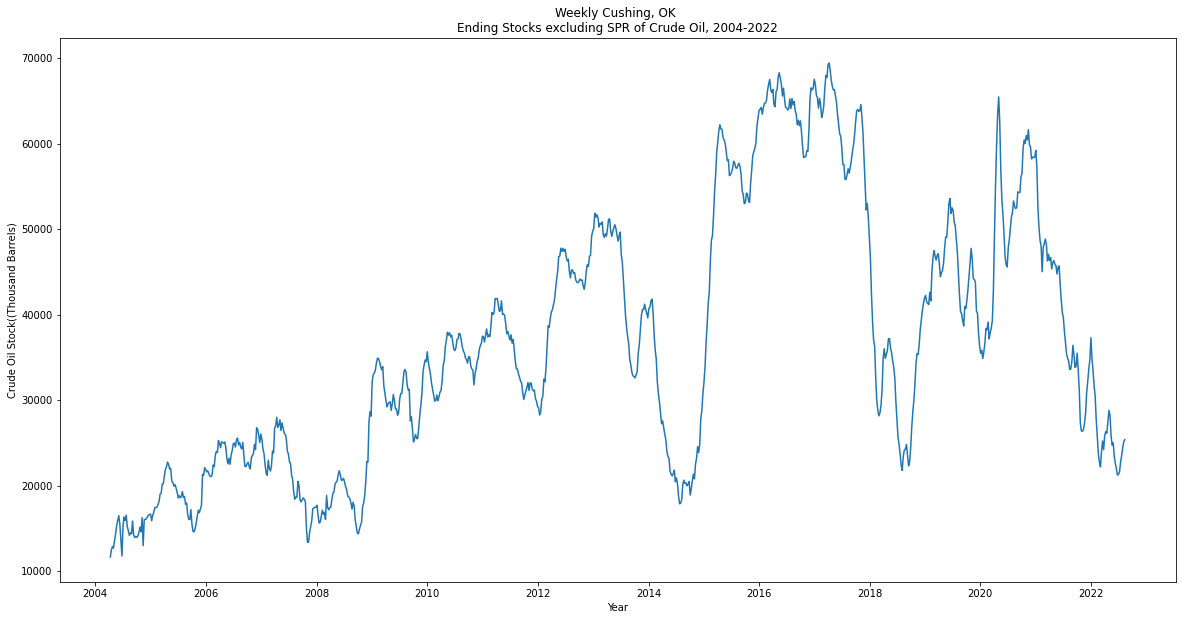

In [14]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.plot(Energy_info_datevalues['Date'], Energy_info_datevalues['Value'])
plt.xlabel('Year')
plt.ylabel('Crude Oil Stock((Thousand Barrels)')
plt.title('Weekly Cushing, OK \nEnding Stocks excluding SPR of Crude Oil, 2004-2022')
plt.show()

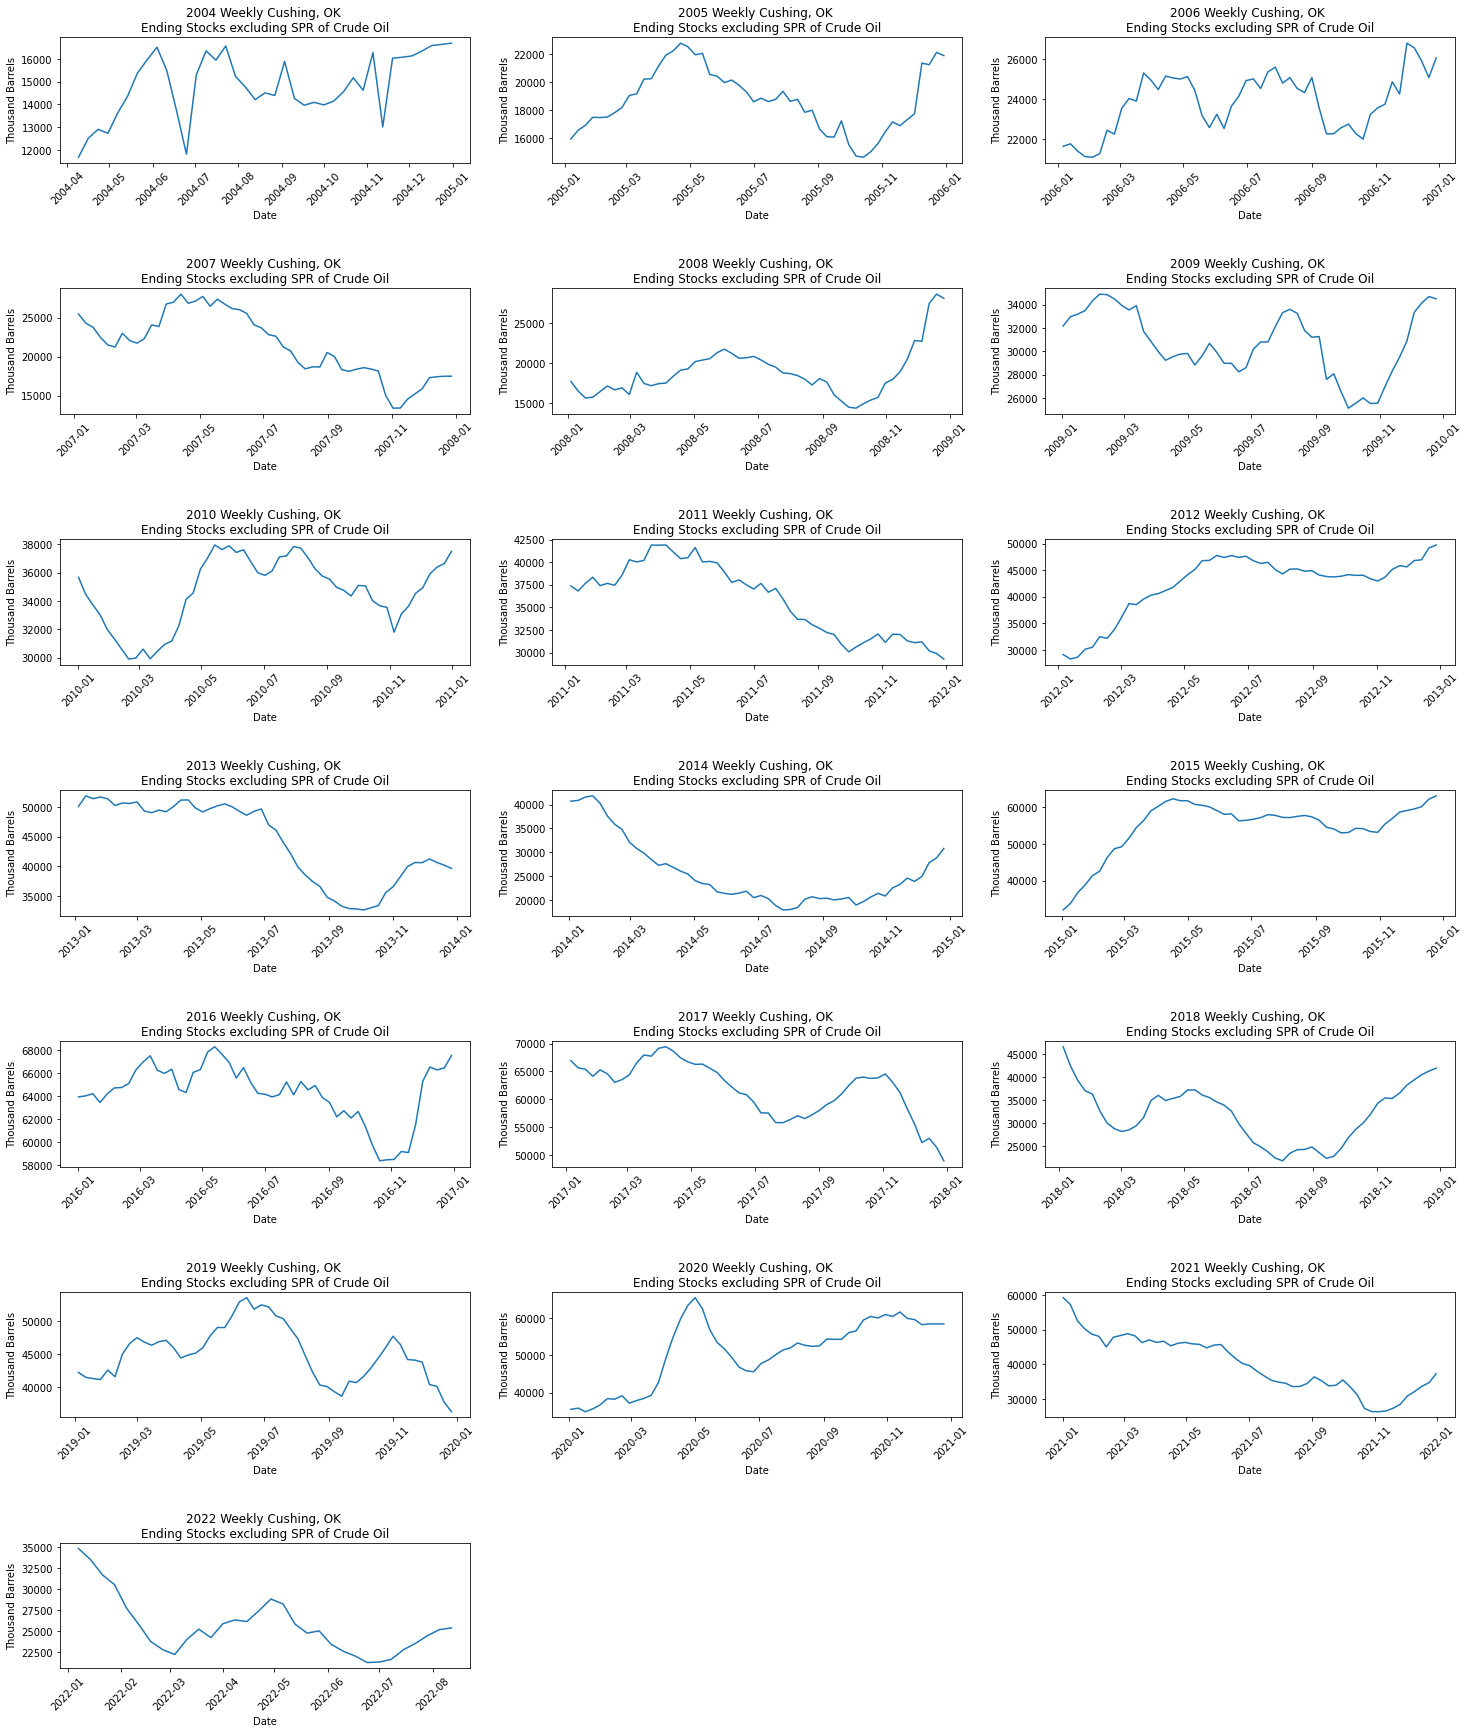

In [15]:
Energy_info_datevalues['Year'] = Energy_info_datevalues['Date'].apply(lambda x: x.year)
groups = Energy_info_datevalues.groupby('Year')
Energy_info_by_yaer = []
for count,df in groups:
    Energy_info_by_yaer.append(df.drop(columns = 'Year'))
plt.figure(figsize=(25, 30))
plt.subplots_adjust(hspace=1)
for n, df in enumerate(Energy_info_by_yaer):
    ax = plt.subplot(7, 3, n + 1)
    ax.plot(Energy_info_by_yaer[n]['Date'], Energy_info_by_yaer[n]['Value'])
    plt.xticks(rotation = 45)
    year = Energy_info_by_yaer[n].iloc[0]['Date'].year
    plt.title(f'{year} Weekly Cushing, OK \nEnding Stocks excluding SPR of Crude Oil')
    plt.xlabel('Date')
    plt.ylabel('Thousand Barrels')
plt.show()

In [16]:
hstack_df = Energy_info_datevalues.copy()
hstack_df['Year'] = hstack_df['Date'].apply(lambda x: x.year)
def change_year(dt):
    return dt.replace(year = 2000)
hstack_df['Fake_Date'] = hstack_df['Date'].apply(change_year)

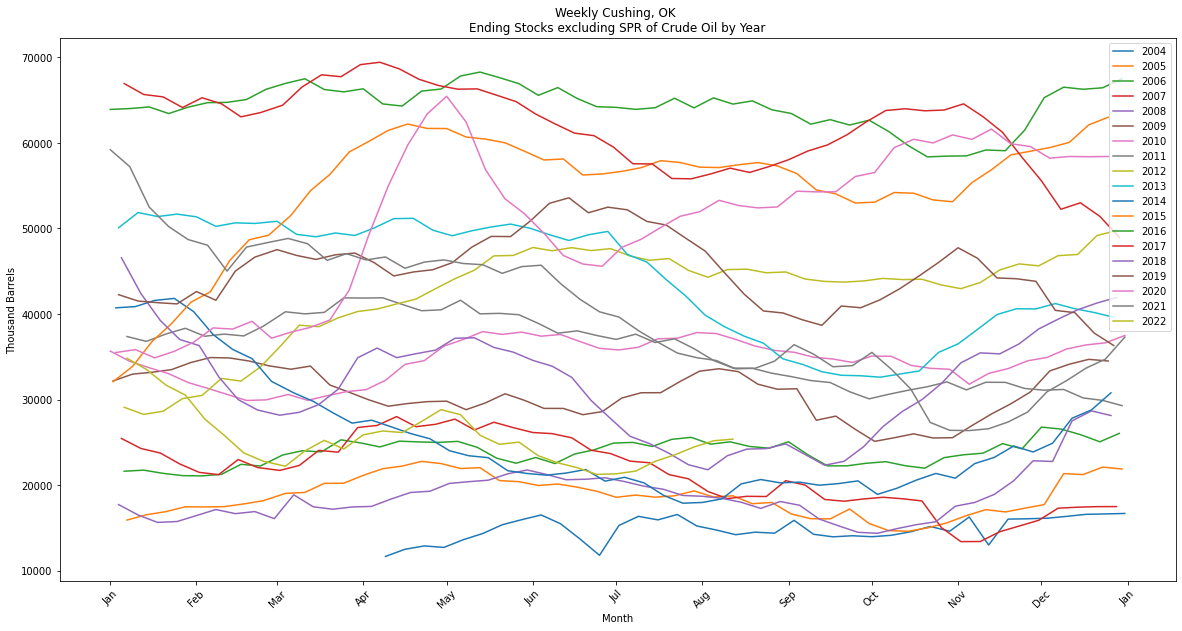

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
groups = hstack_df.groupby('Year')
Energy_info_by_yaer = []
for count,df in groups:
    Energy_info_by_yaer.append(df.drop(columns = 'Year'))
legends = []
for n, df in enumerate(Energy_info_by_yaer):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    year = Energy_info_by_yaer[n].iloc[0]['Date'].year
    legends.append(year)
    ax.plot(Energy_info_by_yaer[n]['Fake_Date'], Energy_info_by_yaer[n]['Value'], label = year)
    plt.xticks(rotation = 45)
    plt.xlabel('Month')
    plt.ylabel('Thousand Barrels')

# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = ['Jan', 'Mar', 'May', 'July', 'Sep', 'Nov', 'Jan']
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.title(f'Weekly Cushing, OK \nEnding Stocks excluding SPR of Crude Oil by Year')
plt.legend(legends)
plt.show()

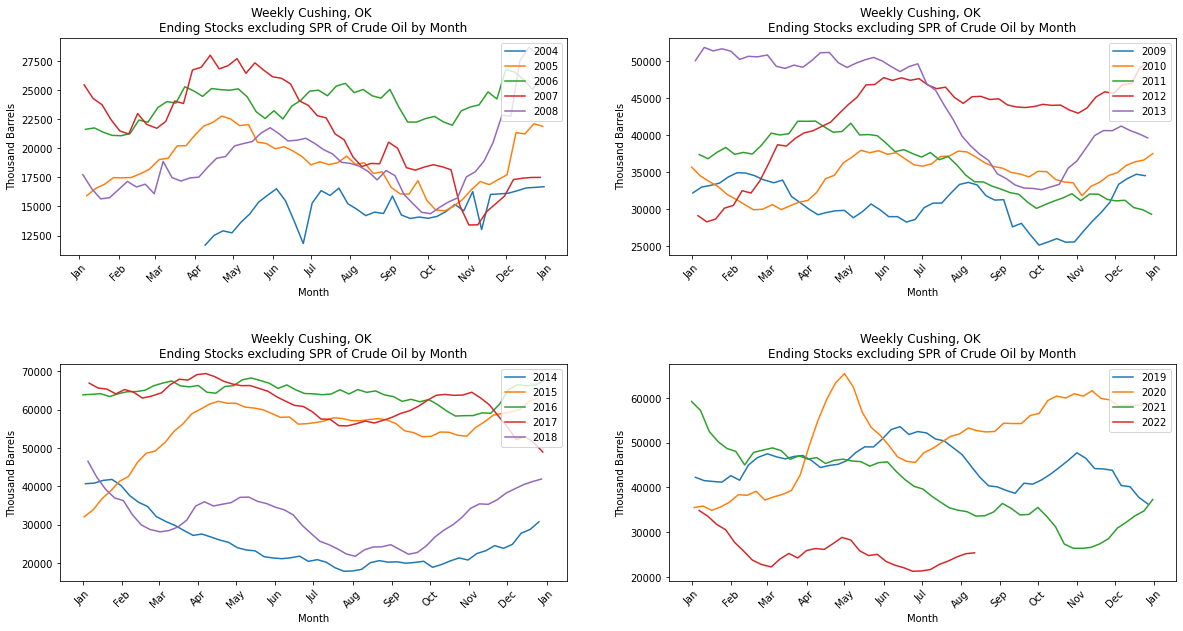

In [18]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
for n, df in enumerate(Energy_info_by_yaer):
    if n % 5 == 0:
        legends = []
        ax = plt.subplot(2, 2, n // 5 + 1)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    year = Energy_info_by_yaer[n].iloc[0]['Date'].year
    legends.append(year)
    ax.plot(Energy_info_by_yaer[n]['Fake_Date'], Energy_info_by_yaer[n]['Value'], label = year)
    plt.xticks(rotation = 45)
    plt.xlabel('Month')
    plt.ylabel('Thousand Barrels')
    plt.title('Weekly Cushing, OK \nEnding Stocks excluding SPR of Crude Oil by Month')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.legend(legends, loc='upper right')
plt.show()

In [19]:
def season_convert(dt):
    spring = [3,4,5]
    summer = [6,7,8]
    fall = [9,10,11]
    if dt.month in spring:
        return 'Spring'
    elif dt.month in summer:
        return 'Summer'
    elif dt.month in fall:
        return 'Fall'
    else:
        return 'Winter'

Energy_info_datevalues['Season'] = Energy_info_datevalues['Date'].apply(season_convert)

In [20]:
summary = Energy_info_datevalues.groupby(['Year', 'Season']).agg('mean')
pd.set_option('display.max_rows', 500)
summary.to_csv('seasonal_mean.csv', encoding='utf-8')

In [21]:
Energy_info_datevalues['Month'] = Energy_info_datevalues['Date'].apply(lambda x: x.month)
summary_month = Energy_info_datevalues.groupby(['Year','Month'])['Value'].agg(['mean', 'max'])
def monthly_max(df):
    return df[df['max'] == df['max'].max()].index.get_level_values(1)[0]

summary_month.groupby('Year').apply(monthly_max)

Year
2004    12
2005     4
2006    12
2007     4
2008    12
2009     2
2010     5
2011     4
2012    12
2013     1
2014     1
2015    12
2016     5
2017     4
2018     1
2019     6
2020     5
2021     1
2022     1
dtype: int64

In [22]:
def monthly_mean(df):
    return df[df['mean'] == df['mean'].max()].index.get_level_values(1)[0]
summary_month.groupby('Year').apply(monthly_mean)

Year
2004    12
2005     4
2006    12
2007     4
2008    12
2009     2
2010     5
2011     4
2012    12
2013     1
2014     1
2015     4
2016     5
2017     4
2018     1
2019     6
2020    11
2021     1
2022     1
dtype: int64

### Seasonality Analysis

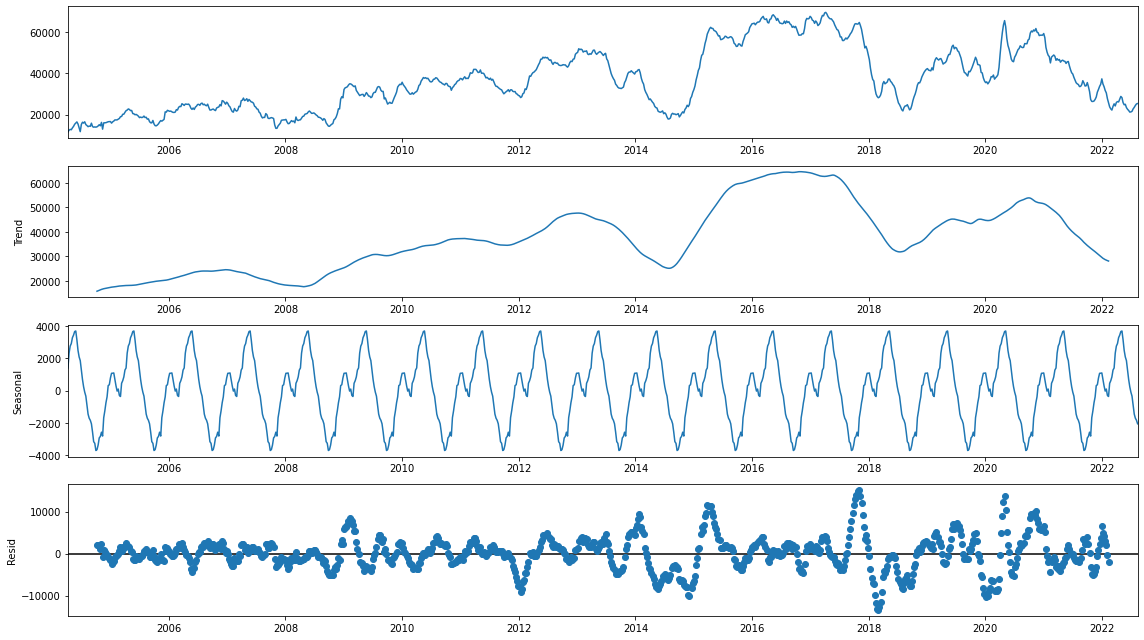

In [23]:
decompose_result_mult = seasonal_decompose(Energy_info_datevalues.set_index('Date')[['Value']], model="addictive")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
fig = decompose_result_mult.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

### Find Gold Price by Web Scraping

In [33]:
# scrape data from website https://tradingeconomics.com/commodity/gold
# The url might change overtime
# url = 'https://markets.tradingeconomics.com/chart?s=xauusd:cur&span=max&securify=new&url=/commodity/gold&AUTH=kguvNBphWg%2FvZ3q6gloVR%2F%2FLtO%2BpjDvlo%2F%2FfTyujijay%2Ba094dH53%2BZswNMqhOy9&ohlc=0'
# r = requests.get(url)

In [34]:
# retrieve data from url
# search_cookies = r.cookies
# post_data = {'method': 'GET'}
# headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
# res_post = requests.get(url, data = post_data, cookies = search_cookies, headers = headers)

In [35]:
# turn data into dataframe
# gold_value = res_post.json()
# dates = []
# prices = []
# percentChanges = []
# for i in gold_value['series'][0]['data']:
#     dates.append(i['date'])
#     prices.append(i['y'])
#     percentChanges.append(i['percentChange'])
# gold_price = pd.DataFrame({'Date': dates, 'Price': prices, 'PercentChange(%)': percentChanges})
# gold_price['Date'] = pd.to_datetime(gold_price['Date'])

In [36]:
# gold_price.to_csv('Gold_Price.csv', index = False)

In [37]:
# gold_price.head()

### Find US Year Treasury by Web Scraping

In [38]:
# url = 'https://ts-api.cnbc.com/harmony/app/charts/ALL.json?symbol=US5Y'
# r = requests.get(url)

In [39]:
# search_cookies = r.cookies
# post_data = {'method': 'GET'}
# headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'}
# res_post = requests.get(url, data = post_data, cookies = search_cookies, headers = headers)

In [40]:
# times = [pd.to_datetime(i['tradeTimeinMills'], unit = 'ms') for i in res_post.json()['barData']['priceBars']]
# close_values = [float(i['close']) for i in res_post.json()['barData']['priceBars']]

In [41]:
# treasury_5yr = pd.DataFrame({'Time': times, 'Close Value': close_values})
# treasury_5yr.head()

In [42]:
# url = 'https://ts-api.cnbc.com/harmony/app/charts/ALL.json?symbol=US10Y'
# r = requests.get(url)

In [43]:
# search_cookies = r.cookies
# post_data = {'method': 'GET'}
# headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'}
# res_post = requests.get(url, data = post_data, cookies = search_cookies, headers = headers)

In [44]:
# times = [pd.to_datetime(i['tradeTimeinMills'], unit = 'ms') for i in res_post.json()['barData']['priceBars']]
# close_values = [float(i['close']) for i in res_post.json()['barData']['priceBars']]

In [45]:
# treasury_10yr = pd.DataFrame({'Time': times, 'Close Value': close_values})
# treasury_10yr.head()

In [46]:
# url = 'https://ts-api.cnbc.com/harmony/app/charts/ALL.json?symbol=US30Y'
# r = requests.get(url)

In [47]:
# search_cookies = r.cookies
# post_data = {'method': 'GET'}
# headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'}
# res_post = requests.get(url, data = post_data, cookies = search_cookies, headers = headers)

In [48]:
# times = [pd.to_datetime(i['tradeTimeinMills'], unit = 'ms') for i in res_post.json()['barData']['priceBars']]
# close_values = [float(i['close']) for i in res_post.json()['barData']['priceBars']]

In [49]:
# treasury_30yr = pd.DataFrame({'Time': times, 'Close Value': close_values})
# treasury_30yr.head()

In [50]:
# Download data from FRED (https://fred.stlouisfed.org/series/DGS10)
DGS5 = pd.read_csv('DGS5.csv')
DGS10 = pd.read_csv('DGS10.csv')
DGS20 = pd.read_csv('DGS20.csv')
DGS30 = pd.read_csv('DGS30.csv')

In [72]:
DGS = DGS5.merge(DGS10, how = 'outer').merge(DGS20, how = 'outer').merge(DGS30, how = 'outer')
DGS['DATE'] = pd.to_datetime(DGS['DATE'])
DGS[DGS['DGS5'] == '.'] = np.nan
DGS.dropna()
DGS_2004 = DGS[DGS['DATE'] >= SPY.iloc[-1]['Date']]
DGS_2004['DGS5'] = DGS_2004['DGS5'].astype('float')
DGS_2004['DGS10'] = DGS_2004['DGS10'].astype('float')
DGS_2004['DGS20'] = DGS_2004['DGS20'].astype('float')
DGS_2004['DGS30'] = DGS_2004['DGS30'].astype('float')

<ipython-input-72-abbf27b82fcc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DGS_2004['DGS5'] = DGS_2004['DGS5'].astype('float')
<ipython-input-72-abbf27b82fcc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DGS_2004['DGS10'] = DGS_2004['DGS10'].astype('float')
<ipython-input-72-abbf27b82fcc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

### Concatenate Dataframes of Crude Oil, SPY, and Gold price into one

In [52]:
gold_price = pd.read_csv('Gold_Price.csv')
gold_price['Date'] = pd.to_datetime(gold_price['Date'])

In [53]:
Crude_oil = Energy_info_datevalues[['Date', 'Value']].rename(columns = {'Value': 'Crude Oil(Thousand Barrels)'})
SPY = SPY_WSJ.rename(columns = {' Open': 'SPY Open Price', ' High': 'SPY High Price', ' Low': 'SPY Low Price', ' Close': 'SPY Close Price'})
Gold_price = gold_price.rename(columns = {'Price': 'Gold Price', 'PercentChange(%)': 'Gold PercentChange(%)'})

In [54]:
merged = Crude_oil.merge(SPY, how = 'outer').merge(Gold_price, how = 'outer').merge(DGS, how = 'outer', left_on = 'Date', right_on = 'DATE')
merged_everydata = merged.sort_values(by = 'Date').reset_index().drop(columns = ['index'])
merged_everydata['Date'] = merged_everydata['Date'].fillna(value=merged_everydata.loc[~merged_everydata['DATE'].isna(),'DATE'])
merged_everydata = merged_everydata.drop(columns = 'DATE')

In [55]:
merged_everydata.head()

Date  Crude Oil(Thousand Barrels)  SPY Open Price  SPY High Price  \
0 1968-01-03                          NaN             NaN             NaN   
1 1968-02-01                          NaN             NaN             NaN   
2 1968-03-01                          NaN             NaN             NaN   
3 1968-04-01                          NaN             NaN             NaN   
4 1968-05-01                          NaN             NaN             NaN   

   SPY Low Price  SPY Close Price  Gold Price  Gold PercentChange(%)  DGS5  \
0            NaN              NaN        35.2                    NaN  5.67   
1            NaN              NaN        35.2               0.000000  5.60   
2            NaN              NaN        39.4              11.931818  5.57   
3            NaN              NaN        39.1              -0.761421  5.64   
4            NaN              NaN        41.3               5.626598  5.92   

  DGS10 DGS20 DGS30  
0  5.63  5.48   NaN  
1  5.58  5.38   NaN  
2  5.56  5.40   NaN  
3  5.64  5.52   NaN  
4  5.73  5.47   NaN

# 2. Exploratory Data Analysis

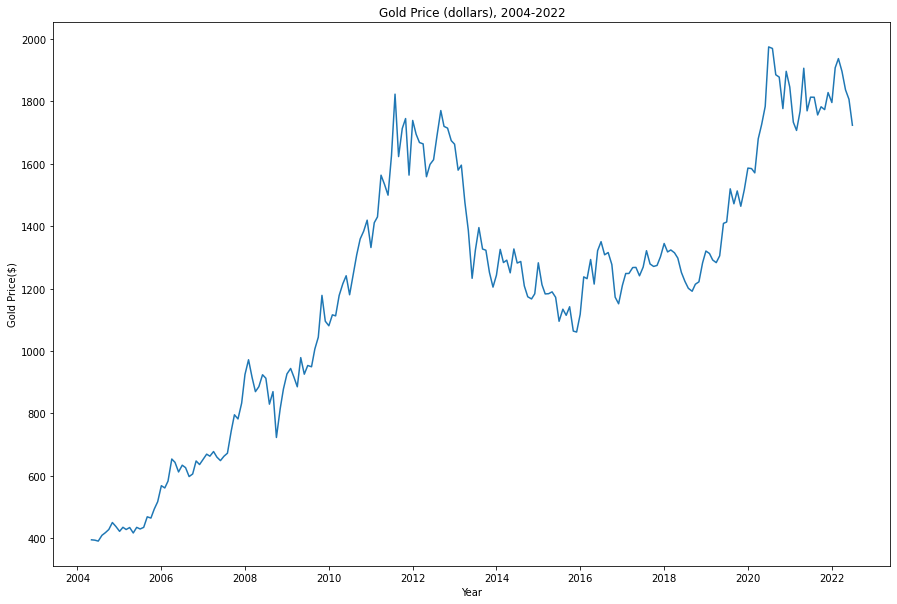

In [56]:
Gold_price2004 = Gold_price[Gold_price['Date'] >= SPY.iloc[-1]['Date']]
plt.figure(figsize=(15, 10))
plt.plot(Gold_price2004['Date'], Gold_price2004['Gold Price'])
plt.title('Gold Price (dollars), 2004-2022')
plt.xlabel('Year')
plt.ylabel('Gold Price($)')
plt.show()

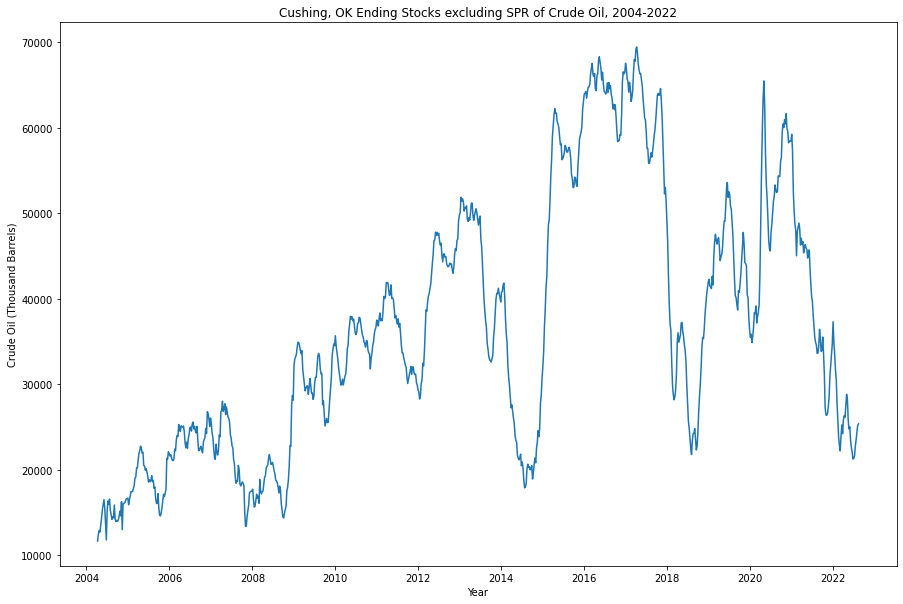

In [57]:
plt.figure(figsize=(15, 10))
plt.plot(Crude_oil['Date'], Crude_oil['Crude Oil(Thousand Barrels)'])
plt.title('Cushing, OK Ending Stocks excluding SPR of Crude Oil, 2004-2022')
plt.xlabel('Year')
plt.ylabel('Crude Oil (Thousand Barrels)')
plt.show()

### Comparison between Crude Oil and Gold Price:  
From the above two graphs, we found that the overall trend looks similar. This is reasonable because [reason? when stock of crude oil decreases, the price of crude oil will increase. When crude oil increases, people will in panic and invest more gold to prevent money inflation. In this case, the gold demand will increases which decreases the gold price]. Since the Except from the period 2015-2019, though the gold prices were relatively smooth and has few fluctuation, there was a sudden increase in crude oil stock at 2015, and the stock stays high until 2019. This peak was led by [reason? a change of American industrial structure (https://www.reuters.com/article/kemp-oil-idCNKCS0R90H820150909)]

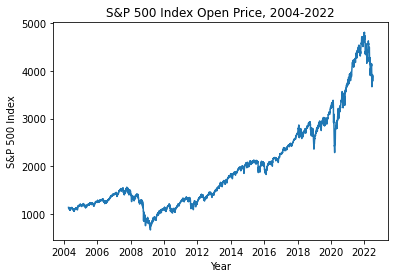

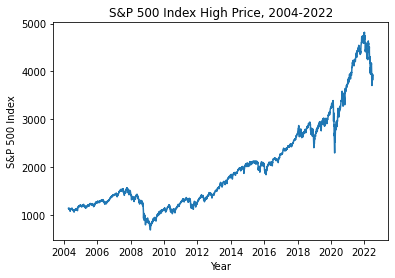

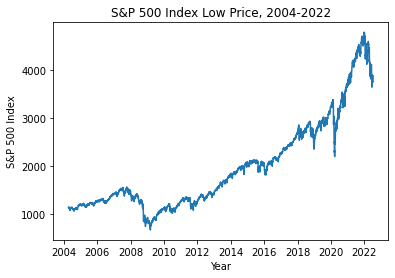

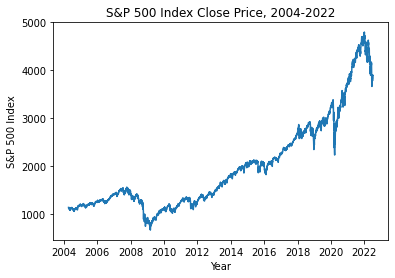

In [58]:
for i in SPY.columns[1:]:
    plt.plot(SPY['Date'], SPY[i])
    plt.title(f'S&P 500 Index {i[4:]}, 2004-2022')
    plt.xlabel('Year')
    plt.ylabel('S&P 500 Index')
    plt.show()

Overall, the trend of S&P 500 Index's close price, low price, high price, and open price share the same trend, though the index amount might differ.

### Overlap of S&P index, crude oil amount, and gold price

In [59]:
# plt.figure(figsize=(15, 10))
# plt.plot(Gold_price2004['Date'], Gold_price2004['Gold Price'])
# plt.plot(Crude_oil['Date'], [i/10 for i in Crude_oil['Crude Oil(Thousand Barrels)']])
# plt.plot(SPY['Date'], SPY['SPY Close Price'])
# plt.legend(['Gold price', 'Crude oil Amount', 'S&P 500 Index'])
# plt.show()

Because the S&P, crude oil, and gold price have different units, the original trends won't overlap with each other. Noticing he fluctuations of value won't be changed after standardization, we standardized three values at the same time. As shown below, the trends overlaps.

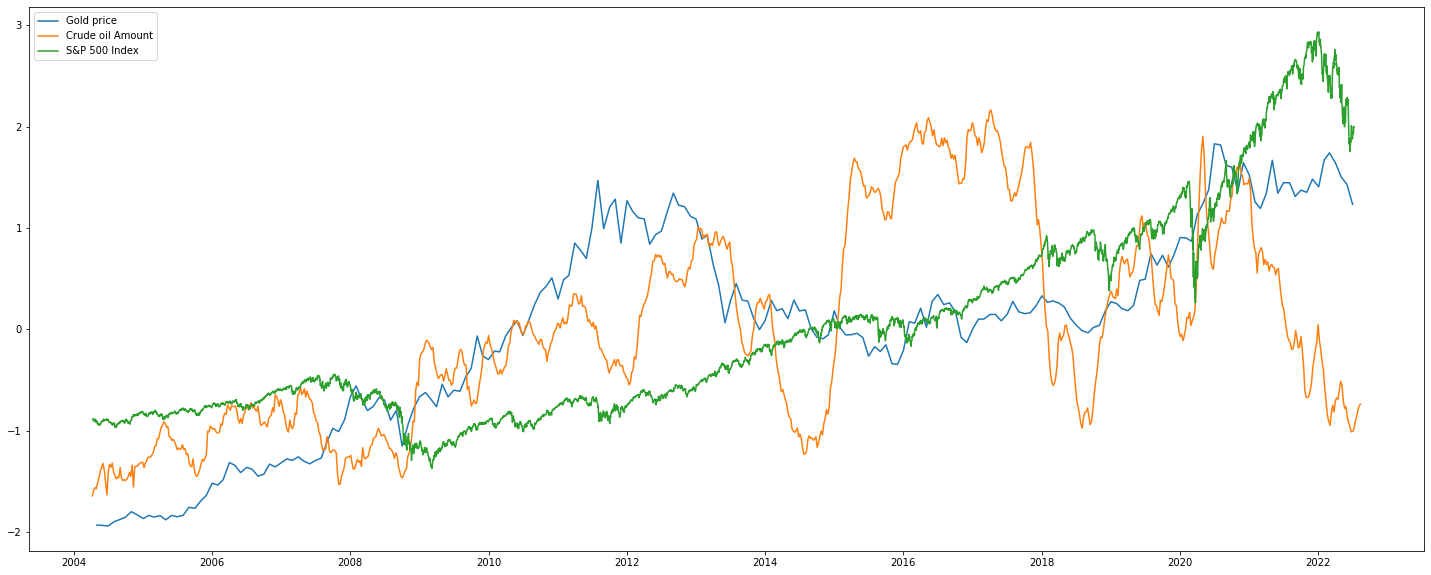

In [60]:
plt.figure(figsize=(25, 10))
plt.plot(Gold_price2004['Date'], preprocessing.scale(Gold_price2004['Gold Price']))
plt.plot(Crude_oil['Date'], preprocessing.scale(Crude_oil['Crude Oil(Thousand Barrels)']))
plt.plot(SPY['Date'], preprocessing.scale(SPY['SPY Close Price']))
plt.legend(['Gold price', 'Crude oil Amount', 'S&P 500 Index'])
plt.show()

# 3. Explore Relationship between Factors in Bull Market

Now we are going to find the bull market via S&P index. We had two definitions:  
1. If the index increases by more or equal to 1.5 percent of the previous month, we consider it as bull market.  
2. If the index increases by more or equal to 20 percent of the same month last year, we consider it as bull market.

In [61]:
# We first find the year and month satisfying the first definition
# Get the year and month of index from date
SPY['Year'] = SPY['Date'].apply(lambda x: x.year)
SPY['Month'] = SPY['Date'].apply(lambda x: x.month)
# Group index by (Year, Month), and here we use close price as our index and calculate the mean
SPY_year_month = SPY.groupby(['Year', 'Month']).agg('mean')[['SPY Close Price']].reset_index()
# Assign the percentage change into the dataframe
SPY_year_month['SPY Monthly Close Price Percentage Change (%)'] = SPY_year_month['SPY Close Price'].pct_change(axis = 0).apply(lambda x: x * 100)
# Find percentage changes which are larger than 1.5
bull_market_SPY = SPY_year_month[SPY_year_month['SPY Monthly Close Price Percentage Change (%)'] >= 1.53]
# Save the data satisfying condition 1 into csv
#bull_market_SPY.to_csv('bull_market_SPY.csv')

In [62]:
# We then find the year and month satisfying the second definition
# First group data by month
groups = SPY_year_month.groupby('Month')
bull_market_SPY_sameperiod = []
# loop through each month, calculate the percentage change, and get the dataframes that satisfying condition 2
for i, df in groups:
    df['SPY Close Price Percentage Change (%)'] = df['SPY Close Price'].pct_change(axis = 0).apply(lambda x: x * 100)
    bull_market_SPY_sameperiod.append(df[df['SPY Close Price Percentage Change (%)'] >= 20])
# concat all dataframes into one, and sort the order
bull_market_SPY_sameperiod = pd.concat(bull_market_SPY_sameperiod).sort_values(by=['Year', 'Month']).reset_index().drop(columns = 'index')
# save the data satisfying condition 2 into csv
bull_market_SPY_sameperiod.to_csv('bull_market_SPY_sameperiod.csv')

In [63]:
# Month and year which satisfying both condition 1 and condition 2
bull_market_SPY_sameperiod[bull_market_SPY_sameperiod['SPY Monthly Close Price Percentage Change (%)'] >= 1.5].reset_index().drop(columns = 'index')

Year  Month  SPY Close Price  \
0   2009     11      1088.069000   
1   2009     12      1110.377727   
2   2010      3      1152.048696   
3   2010      4      1197.316190   
4   2011      2      1321.117895   
5   2011      7      1325.184500   
6   2012      9      1443.419474   
7   2013      5      1639.842727   
8   2013      7      1668.675455   
9   2013     11      1783.541000   
10  2014      3      1863.523333   
11  2014      6      1947.087619   
12  2017      2      2329.910526   
13  2018      1      2789.803810   
14  2019     12      3176.749524   
15  2020      1      3278.202857   
16  2021      4      4141.176190   
17  2021      6      4238.489545   
18  2021      7      4363.712857   
19  2021      8      4454.206364   
20  2021     11      4667.386667   

    SPY Monthly Close Price Percentage Change (%)  \
0                                        1.911217   
1                                        2.050304   
2                                        5.774055   
3                                        3.929304   
4                                        3.001625   
5                                        2.943851   
6                                        2.848645   
7                                        4.401882   
8                                        3.082765   
9                                        3.692645   
10                                       2.558487   
11                                       3.033203   
12                                       2.408428   
13                                       4.708982   
14                                       2.313921   
15                                       3.193621   
16                                       5.898669   
17                                       1.694880   
18                                       2.954432   
19                                       2.073773   
20                                       4.633335   

    SPY Close Price Percentage Change (%)  
0                               23.218467  
1                               26.529859  
2                               52.160598  
3                               41.167659  
4                               21.296953  
5                               22.724617  
6                               22.961516  
7                               22.260201  
8                               22.716920  
9                               27.897108  
10                              20.163044  
11                              20.281733  
12                              22.342359  
13                              22.622486  
14                              23.738574  
15                              25.727369  
16                              49.935312  
17                              36.520208  
18                              36.042115  
19                              31.326274  
20                              31.513005

In [64]:
# Month and year which satisfying either condition 1 or condition 2
bull_market_SPY_sameperiod.merge(bull_market_SPY, how = 'outer').sort_values(by = ['Year', 'Month']).reset_index().drop(columns = 'index')

Year  Month  SPY Close Price  \
0    2004      6      1132.757143   
1    2004      9      1117.656190   
2    2004     11      1168.936667   
3    2004     12      1199.210909   
4    2005      2      1199.626842   
5    2005      6      1202.255455   
6    2005      7      1222.237000   
7    2005     11      1237.368571   
8    2005     12      1262.071905   
9    2006      8      1287.151304   
10   2006      9      1317.805000   
11   2006     10      1363.384545   
12   2006     11      1388.631905   
13   2006     12      1416.420000   
14   2007      4      1463.647500   
15   2007      5      1511.136818   
16   2007      6      1514.489524   
17   2007      7      1520.704762   
18   2007      9      1497.116316   
19   2007     10      1539.659130   
20   2008      4      1370.469091   
21   2008      5      1403.217619   
22   2008      8      1281.472381   
23   2009      4       848.151905   
24   2009      5       902.408500   
25   2009      6       926.115000   
26   2009      8      1009.724762   
27   2009      9      1044.552381   
28   2009     10      1067.663636   
29   2009     11      1088.069000   
30   2009     12      1110.377727   
31   2010      1      1123.581579   
32   2010      2      1089.160000   
33   2010      3      1152.048696   
34   2010      4      1197.316190   
35   2010      5      1125.063500   
36   2010      9      1122.081905   
37   2010     10      1171.583810   
38   2010     11      1198.888571   
39   2010     12      1241.525455   
40   2011      1      1282.618500   
41   2011      2      1321.117895   
42   2011      4      1331.505000   
43   2011      7      1325.184500   
44   2011     10      1207.216190   
45   2011     11      1226.414286   
46   2012      1      1300.577500   
47   2012      2      1352.487500   
48   2012      3      1389.240000   
49   2012      7      1359.776190   
50   2012      8      1403.440435   
51   2012      9      1443.419474   
52   2012     12      1422.285500   
53   2013      1      1480.395238   
54   2013      2      1512.311579   
55   2013      3      1550.829000   
56   2013      5      1639.842727   
57   2013      6      1618.772500   
58   2013      7      1668.675455   
59   2013     10      1720.026522   
60   2013     11      1783.541000   
61   2013     12      1807.775238   
62   2014      1      1822.356667   
63   2014      2      1817.034737   
64   2014      3      1863.523333   
65   2014      6      1947.087619   
66   2014      9      1993.226190   
67   2014     11      2044.572105   
68   2015      2      2082.195789   
69   2015     10      2024.812727   
70   2015     11      2080.616500   
71   2016      3      2021.954091   
72   2016      4      2075.535238   
73   2016      7      2148.902000   
74   2016     12      2246.629048   
75   2017      2      2329.910526   
76   2017      3      2366.822174   
77   2017      6      2433.985455   
78   2017     10      2556.997273   
79   2017     12      2664.340500   
80   2018      1      2789.803810   
81   2018      5      2701.493636   
82   2018      6      2754.352857   
83   2018      8      2857.820435   
84   2019      1      2607.390000   
85   2019      2      2754.864211   
86   2019      3      2803.983810   
87   2019      4      2903.800000   
88   2019      7      2996.113636   
89   2019      9      2982.156000   
90   2019     11      3104.904500   
91   2019     12      3176.749524   
92   2020      1      3278.202857   
93   2020      4      2761.975238   
94   2020      5      2919.615000   
95   2020      6      3104.660909   
96   2020      7      3207.619091   
97   2020      8      3391.710000   
98   2020     10      3418.701364   
99   2020     11      3548.992500   
100  2020     12      3695.310000   
101  2021      1      3793.748421   
102  2021      2      3883.432105   
103  2021      3      3910.508261   
104  2021      4      4141.176190   
105  2021      5      4167.849500   
106  2021      6      4238.489545   
107  2021

In [65]:
# after our investigation, we consider the 2007.09-2008.02, 2010.03-2010.07, 2014.02-2014.07, 2017.05-2017.08, 
# and 2021.11-2022.03 as the end of bull market
query = [[2007, (9, 12)], [2008, (1, 2)], [2010, (3, 7)], [2014, (2, 7)], [2017, (5, 8)], \
         [2021, (11, 12)], [2022, (1, 3)]]
compared = [[2007, (6, 8)], [2008, (6, 8)], [2010, (6, 8)], [2014, (6, 8)], [2017, (6, 8)],\
            [2021, (6, 8)], [2022, (6, 8)]]
dfs = []
dfs_compared = []
for i in query:
    dfs.append(merged_everydata[merged_everydata['Date'].apply(lambda x: x.year == i[0] \
                                                               and (i[1][0] <= x.month <= i[1][1]))])
for j in compared:
    dfs_compared.append(merged_everydata[merged_everydata['Date'].apply(lambda x: x.year == j[0] \
                                                                        and (j[1][0] <= x.month <= j[1][1]))])

In [66]:
# combine the data from end of bull market and standardize the crude oil, S&P index and gold price
target = pd.concat(dfs)
target['Crude Oil(Thousand Barrels)_std'] = preprocessing.scale(target['Crude Oil(Thousand Barrels)'])
target['SPY Close Price_std'] = preprocessing.scale(target['SPY Close Price'])
target['Gold Price_std'] = preprocessing.scale(target['Gold Price'])
target['DGS5_std'] = preprocessing.scale(target['DGS5'])
target['DGS10_std'] = preprocessing.scale(target['DGS10'])
target['DGS20_std'] = preprocessing.scale(target['DGS20'])
target['DGS30_std'] = preprocessing.scale(target['DGS30'])

In [67]:
# combine the data from June to August to compare the same year's data
target_compared = pd.concat(dfs_compared)
target_compared['Crude Oil(Thousand Barrels)_std'] = preprocessing.scale(target_compared['Crude Oil(Thousand Barrels)'])
target_compared['SPY Close Price_std'] = preprocessing.scale(target_compared['SPY Close Price'])
target_compared['Gold Price_std'] = preprocessing.scale(target_compared['Gold Price'])
target_compared['DGS5_std'] = preprocessing.scale(target_compared['DGS5'])
target_compared['DGS10_std'] = preprocessing.scale(target_compared['DGS10'])
target_compared['DGS20_std'] = preprocessing.scale(target_compared['DGS20'])
target_compared['DGS30_std'] = preprocessing.scale(target_compared['DGS30'])

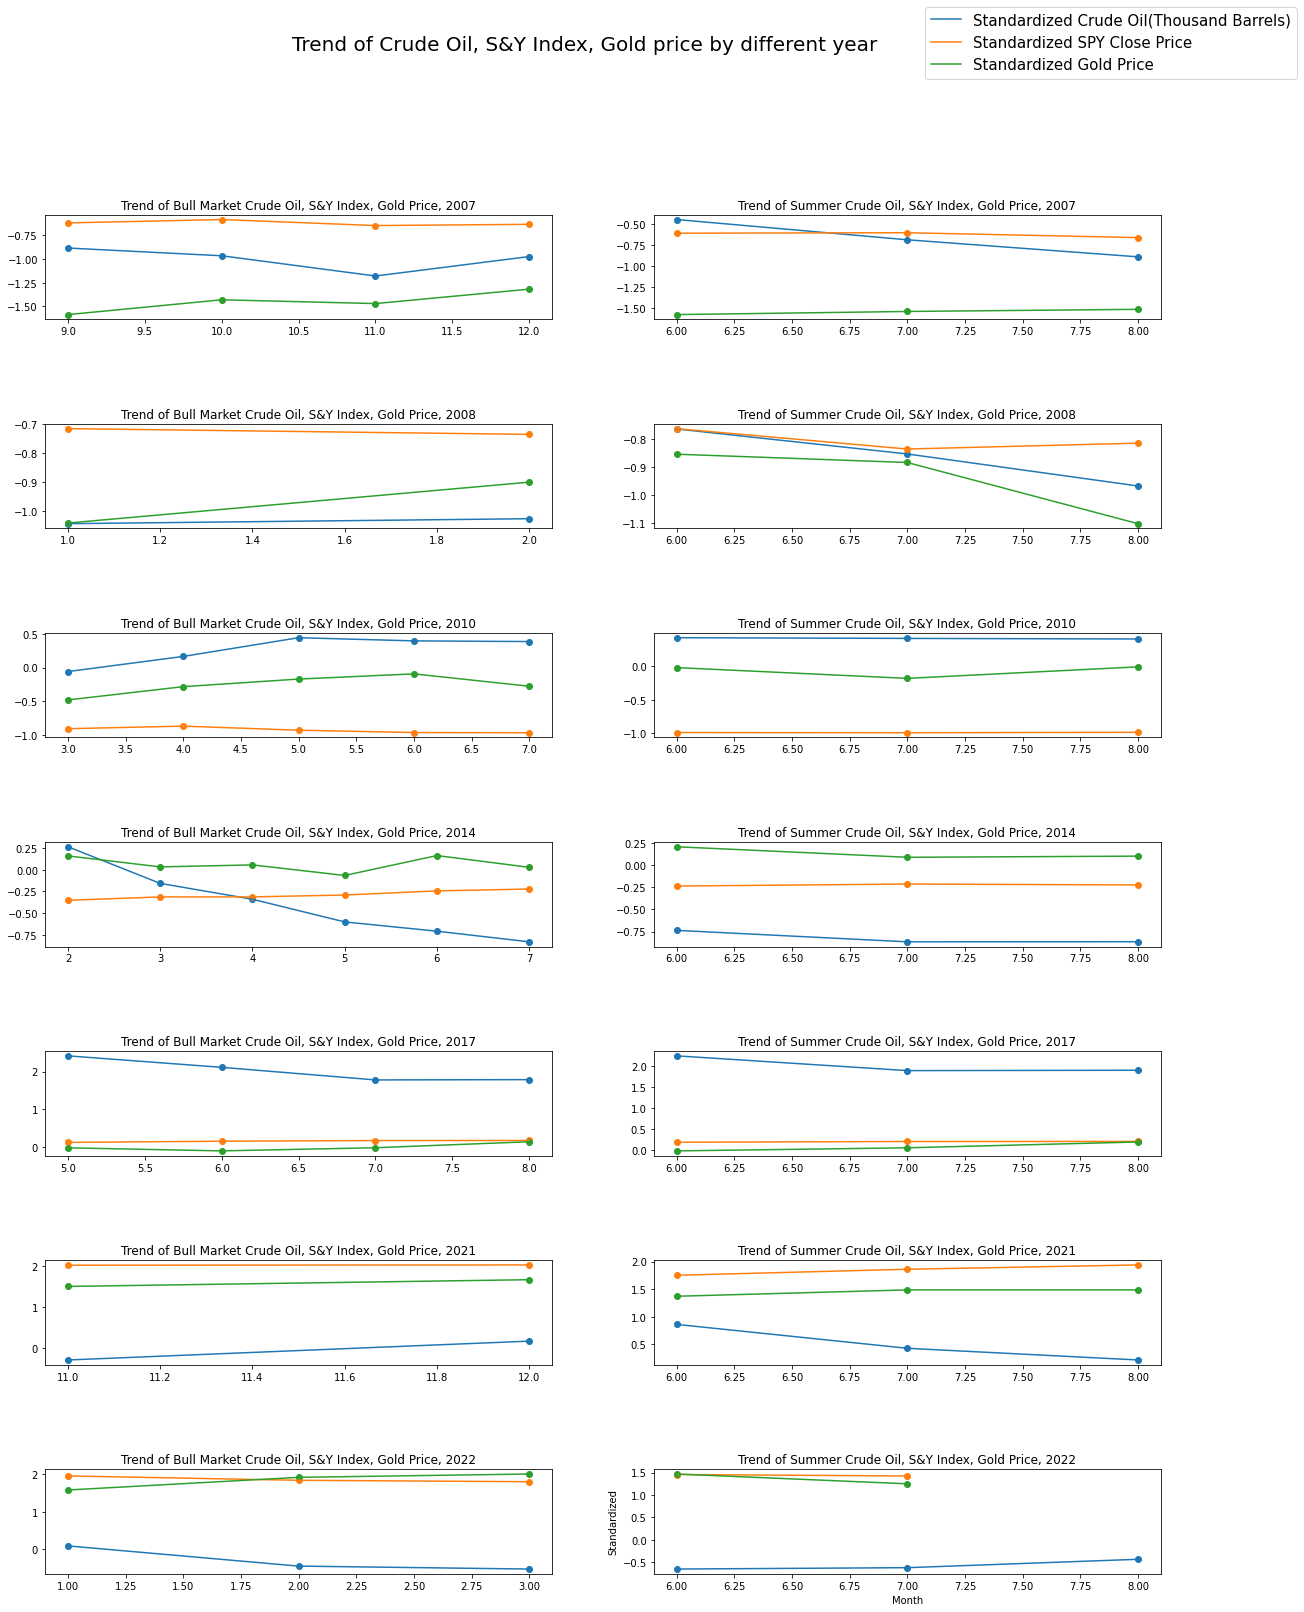

In [68]:
# plot the bull market and compare it with the same year's standardized data in June-August
target['Month'] = target['Date'].apply(lambda x: x.month)
target['Year'] = target['Date'].apply(lambda x: x.year)
target_compared['Month'] = target_compared['Date'].apply(lambda x: x.month)
target_compared['Year'] = target_compared['Date'].apply(lambda x: x.year)
groups = target.groupby(['Year', 'Month']).mean().reset_index().groupby('Year')
groups_compared = target_compared.groupby(['Year', 'Month']).mean().reset_index().groupby('Year')
fig = plt.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=1)
axes = fig.subplots(nrows=len(groups), ncols=2)
for i, df in enumerate(groups):
    ax = fig.axes[i * 2]
    ax.scatter(df[1]['Month'], df[1]['Crude Oil(Thousand Barrels)_std'])
    ax.plot(df[1]['Month'], df[1]['Crude Oil(Thousand Barrels)_std'])
    ax.scatter(df[1]['Month'], df[1]['SPY Close Price_std'])
    ax.plot(df[1]['Month'], df[1]['SPY Close Price_std'])
    ax.scatter(df[1]['Month'], df[1]['Gold Price_std'])
    ax.plot(df[1]['Month'], df[1]['Gold Price_std'])
    ax.title.set_text(f'Trend of Bull Market Crude Oil, S&Y Index, Gold Price, {df[0]}')
    plt.xlabel('Month')
    plt.ylabel('Standardized')
    
    ax = fig.axes[i * 2 + 1]
    df_compared = groups_compared.get_group(list(groups_compared.groups.keys())[i])
    ax.scatter(df_compared['Month'], df_compared['Crude Oil(Thousand Barrels)_std'])
    ax.plot(df_compared['Month'], df_compared['Crude Oil(Thousand Barrels)_std'])
    ax.scatter(df_compared['Month'], df_compared['SPY Close Price_std'])
    ax.plot(df_compared['Month'], df_compared['SPY Close Price_std'])
    ax.scatter(df_compared['Month'], df_compared['Gold Price_std'])
    ax.plot(df_compared['Month'], df_compared['Gold Price_std'])
    plt.xlabel('Month')
    plt.ylabel('Standardized')
    ax.title.set_text(f'Trend of Summer Crude Oil, S&Y Index, Gold Price, {df[0]}')
fig.legend(['Standardized Crude Oil(Thousand Barrels)', 'Standardized SPY Close Price', \
            'Standardized Gold Price'], loc='upper right', prop={'size': 15})
fig.suptitle('Trend of Crude Oil, S&Y Index, Gold price by different year', size = 20)
plt.show()

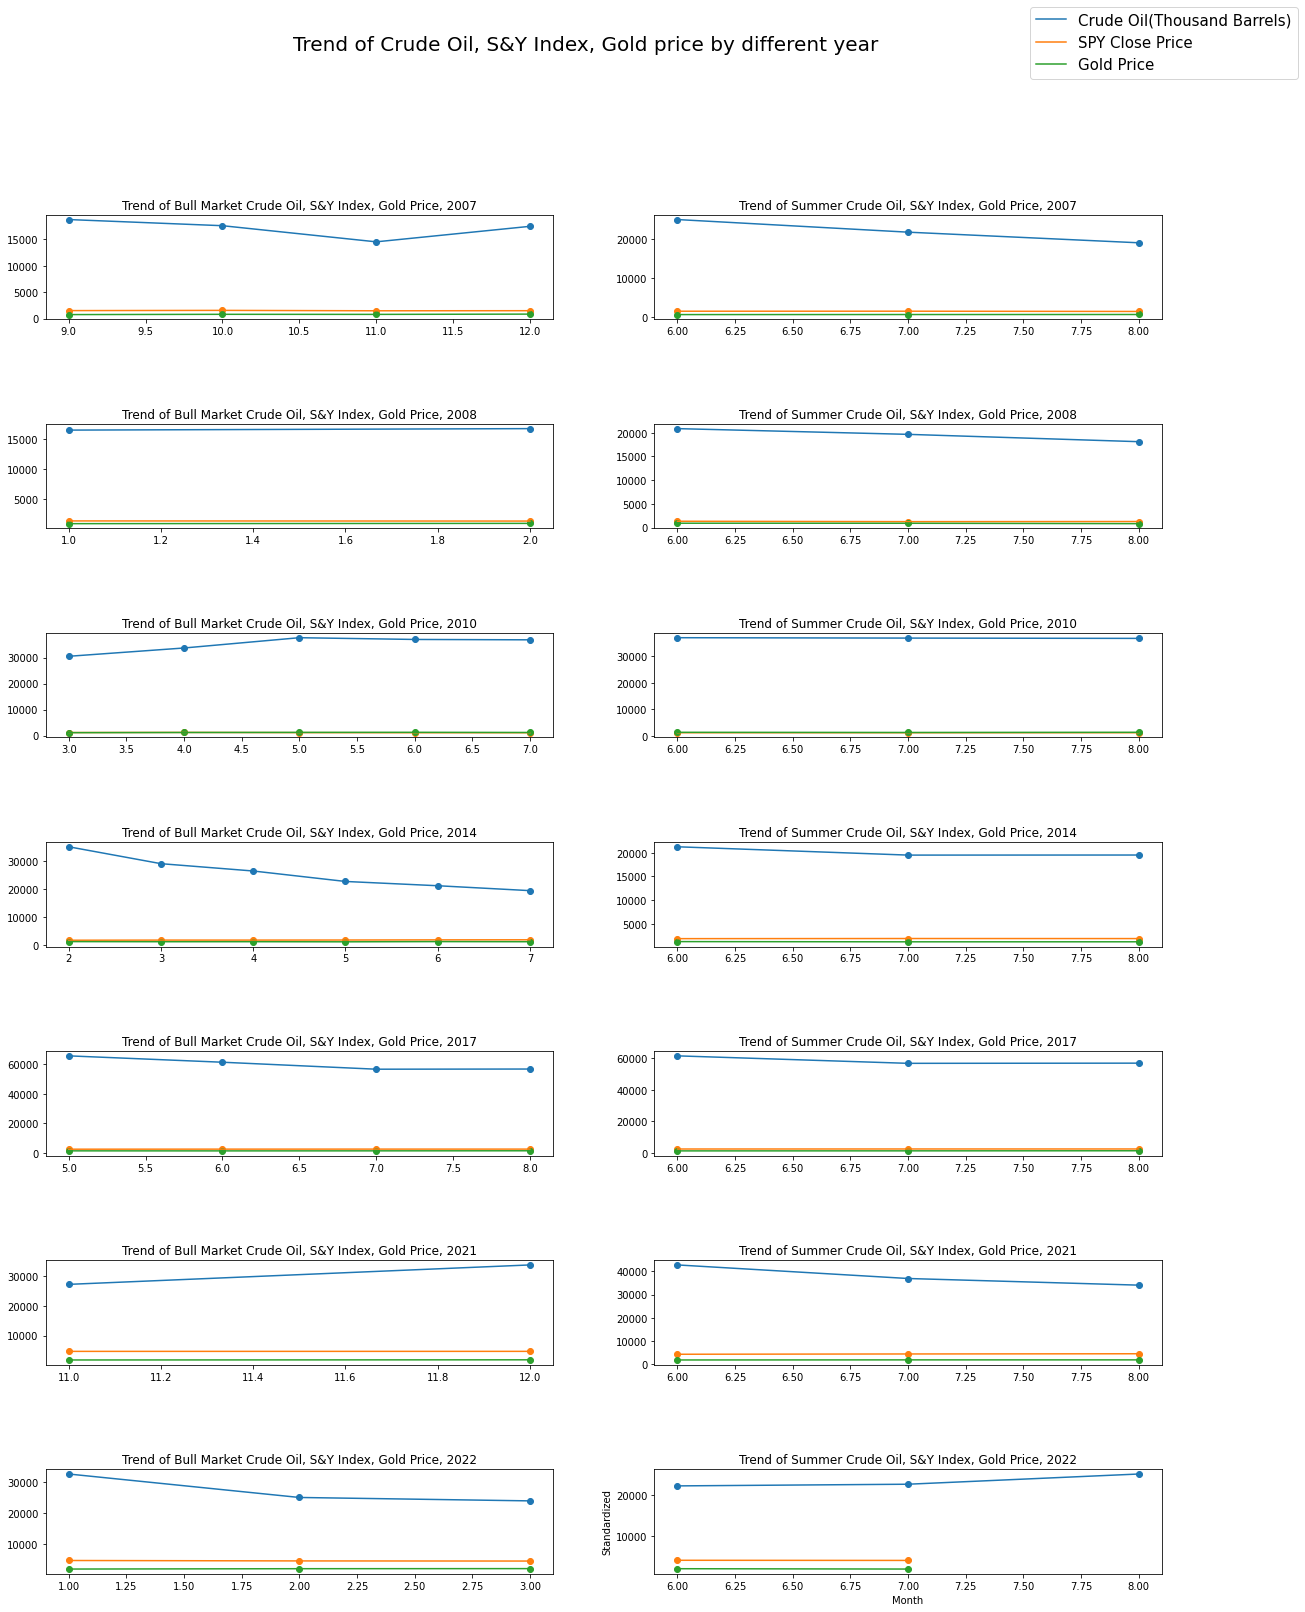

In [69]:
# plot the bull market and compare it with the same year's data in June-August
target['Month'] = target['Date'].apply(lambda x: x.month)
target['Year'] = target['Date'].apply(lambda x: x.year)
target_compared['Month'] = target_compared['Date'].apply(lambda x: x.month)
target_compared['Year'] = target_compared['Date'].apply(lambda x: x.year)
groups = target.groupby(['Year', 'Month']).mean().reset_index().groupby('Year')
groups_compared = target_compared.groupby(['Year', 'Month']).mean().reset_index().groupby('Year')
fig = plt.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=1)
axes = fig.subplots(nrows=len(groups), ncols=2)
for i, df in enumerate(groups):

    ax = fig.axes[i * 2]
    ax.scatter(df[1]['Month'], df[1]['Crude Oil(Thousand Barrels)'])
    ax.plot(df[1]['Month'], df[1]['Crude Oil(Thousand Barrels)'])
    ax.scatter(df[1]['Month'], df[1]['SPY Close Price'])
    ax.plot(df[1]['Month'], df[1]['SPY Close Price'])
    ax.scatter(df[1]['Month'], df[1]['Gold Price'])
    ax.plot(df[1]['Month'], df[1]['Gold Price'])
    ax.title.set_text(f'Trend of Bull Market Crude Oil, S&Y Index, Gold Price, {df[0]}')
    plt.xlabel('Month')
    plt.ylabel('Standardized')
    
    ax = fig.axes[i * 2 + 1]
    df_compared = groups_compared.get_group(list(groups_compared.groups.keys())[i])
    ax.scatter(df_compared['Month'], df_compared['Crude Oil(Thousand Barrels)'])
    ax.plot(df_compared['Month'], df_compared['Crude Oil(Thousand Barrels)'])
    ax.scatter(df_compared['Month'], df_compared['SPY Close Price'])
    ax.plot(df_compared['Month'], df_compared['SPY Close Price'])
    ax.scatter(df_compared['Month'], df_compared['Gold Price'])
    ax.plot(df_compared['Month'], df_compared['Gold Price'])
    plt.xlabel('Month')
    plt.ylabel('Standardized')
    ax.title.set_text(f'Trend of Summer Crude Oil, S&Y Index, Gold Price, {df[0]}')
fig.legend(['Crude Oil(Thousand Barrels)', 'SPY Close Price', 'Gold Price'], \
           loc='upper right', prop={'size': 15})
fig.suptitle('Trend of Crude Oil, S&Y Index, Gold price by different year', size = 20)
plt.show()

### Investigate the relationship between Market Yield on U.S. Treasury Securities and Bull Market 

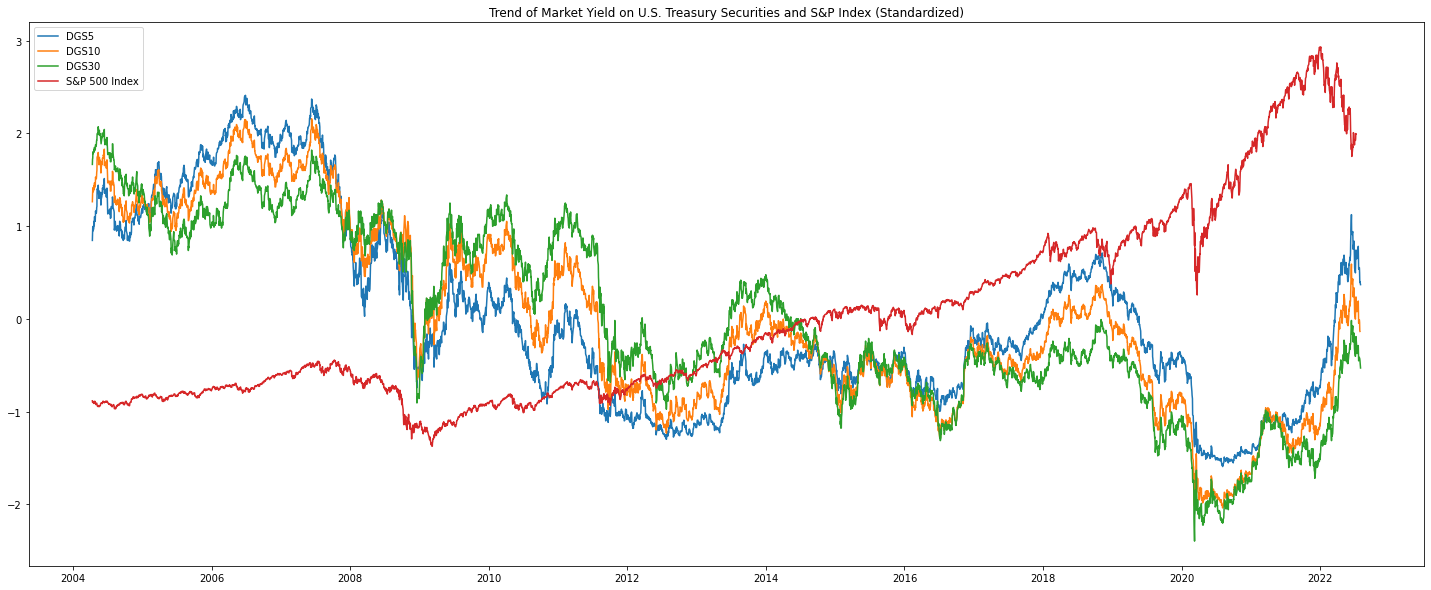

In [73]:
plt.figure(figsize=(25, 10))
plt.plot(DGS_2004['DATE'], preprocessing.scale(DGS_2004['DGS5']))
plt.plot(DGS_2004['DATE'], preprocessing.scale(DGS_2004['DGS10']))
plt.plot(DGS_2004['DATE'], preprocessing.scale(DGS_2004['DGS30']))
plt.plot(SPY['Date'], preprocessing.scale(SPY['SPY Close Price']))
plt.legend(['DGS5', 'DGS10', 'DGS30', 'S&P 500 Index'])
plt.title('Trend of Market Yield on U.S. Treasury Securities and S&P Index (Standardized)')
plt.show()

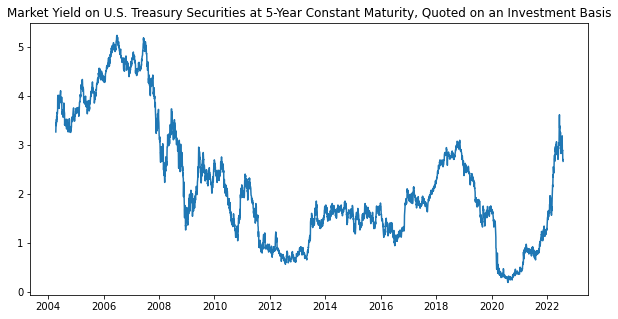

In [74]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(DGS_2004['DATE'], DGS_2004['DGS5'])
plt.title('Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis')
plt.show()

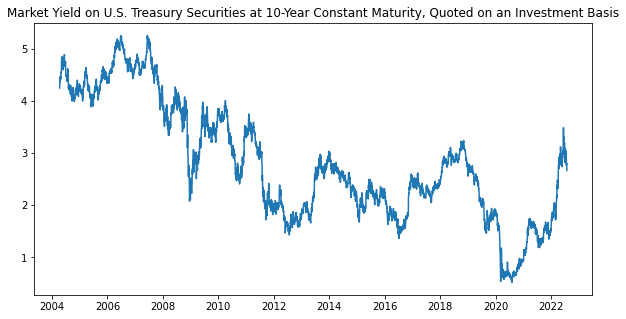

In [75]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(DGS_2004['DATE'], DGS_2004['DGS10'])
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis')
plt.show()

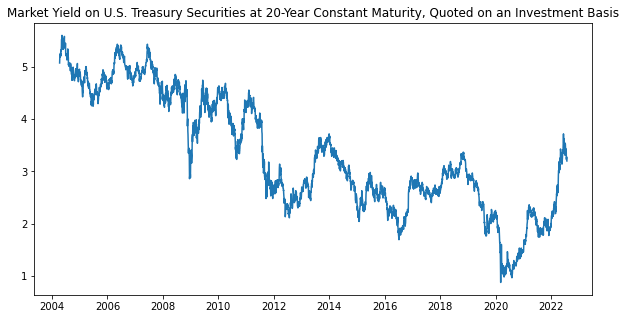

In [76]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(DGS_2004['DATE'], DGS_2004['DGS20'])
plt.title('Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis')
plt.show()

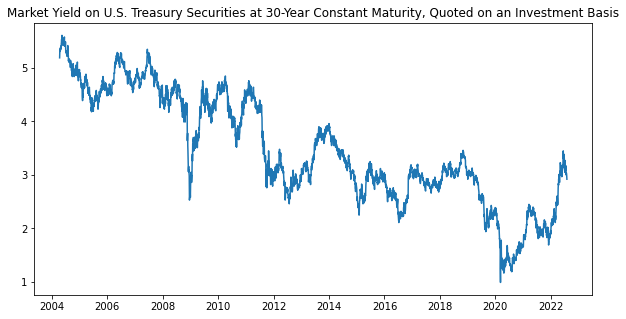

In [77]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(DGS_2004['DATE'], DGS_2004['DGS30'])
plt.title('Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis')
plt.show()

In [78]:
groups = SPY.groupby('Year')
SPY_peak = []
for i, df in groups:
    SPY_peak.append([df.loc[df['SPY Close Price'].idxmax()]['Date'], df.loc[df['SPY Close Price'].idxmax()]['SPY Close Price']])
SPY_peak

[[Timestamp('2004-12-30 00:00:00'), 1213.55],
 [Timestamp('2005-12-14 00:00:00'), 1272.74],
 [Timestamp('2006-12-15 00:00:00'), 1427.09],
 [Timestamp('2007-10-09 00:00:00'), 1565.15],
 [Timestamp('2008-01-03 00:00:00'), 1447.16],
 [Timestamp('2009-12-28 00:00:00'), 1127.78],
 [Timestamp('2010-12-29 00:00:00'), 1259.78],
 [Timestamp('2011-04-29 00:00:00'), 1363.61],
 [Timestamp('2012-09-14 00:00:00'), 1465.77],
 [Timestamp('2013-12-31 00:00:00'), 1848.36],
 [Timestamp('2014-12-29 00:00:00'), 2090.57],
 [Timestamp('2015-05-21 00:00:00'), 2130.82],
 [Timestamp('2016-12-13 00:00:00'), 2271.72],
 [Timestamp('2017-12-18 00:00:00'), 2690.16],
 [Timestamp('2018-09-20 00:00:00'), 2930.75],
 [Timestamp('2019-12-27 00:00:00'), 3240.02],
 [Timestamp('2020-12-31 00:00:00'), 3756.07],
 [Timestamp('2021-12-29 00:00:00'), 4793.06],
 [Timestamp('2022-01-03 00:00:00'), 4796.56]]

In [79]:
DGS_2004['Year'] = DGS_2004['DATE'].apply(lambda x: x.year)
DGS_2004['Month'] = DGS_2004['DATE'].apply(lambda x: x.month)
groups = DGS_2004.groupby('Year')
DGS5_peak = []
for i, df in groups:
    DGS5_peak.append([df.loc[df['DGS5'].idxmax()]['DATE'], df.loc[df['DGS5'].idxmax()]['DGS5']])
DGS5_peak

<ipython-input-79-8f28f253f1c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DGS_2004['Year'] = DGS_2004['DATE'].apply(lambda x: x.year)
<ipython-input-79-8f28f253f1c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DGS_2004['Month'] = DGS_2004['DATE'].apply(lambda x: x.month)


[[Timestamp('2004-06-14 00:00:00'), 4.1],
 [Timestamp('2005-11-04 00:00:00'), 4.56],
 [Timestamp('2006-06-28 00:00:00'), 5.23],
 [Timestamp('2007-06-12 00:00:00'), 5.18],
 [Timestamp('2008-06-13 00:00:00'), 3.73],
 [Timestamp('2009-06-08 00:00:00'), 2.95],
 [Timestamp('2010-04-05 00:00:00'), 2.75],
 [Timestamp('2011-02-10 00:00:00'), 2.4],
 [Timestamp('2012-03-20 00:00:00'), 1.22],
 [Timestamp('2013-09-05 00:00:00'), 1.85],
 [Timestamp('2014-09-18 00:00:00'), 1.85],
 [Timestamp('2015-12-29 00:00:00'), 1.81],
 [Timestamp('2016-12-15 00:00:00'), 2.1],
 [Timestamp('2017-12-21 00:00:00'), 2.26],
 [Timestamp('2018-11-08 00:00:00'), 3.09],
 [Timestamp('2019-01-18 00:00:00'), 2.62],
 [Timestamp('2020-01-02 00:00:00'), 1.67],
 [Timestamp('2021-11-24 00:00:00'), 1.34],
 [Timestamp('2022-06-14 00:00:00'), 3.61]]

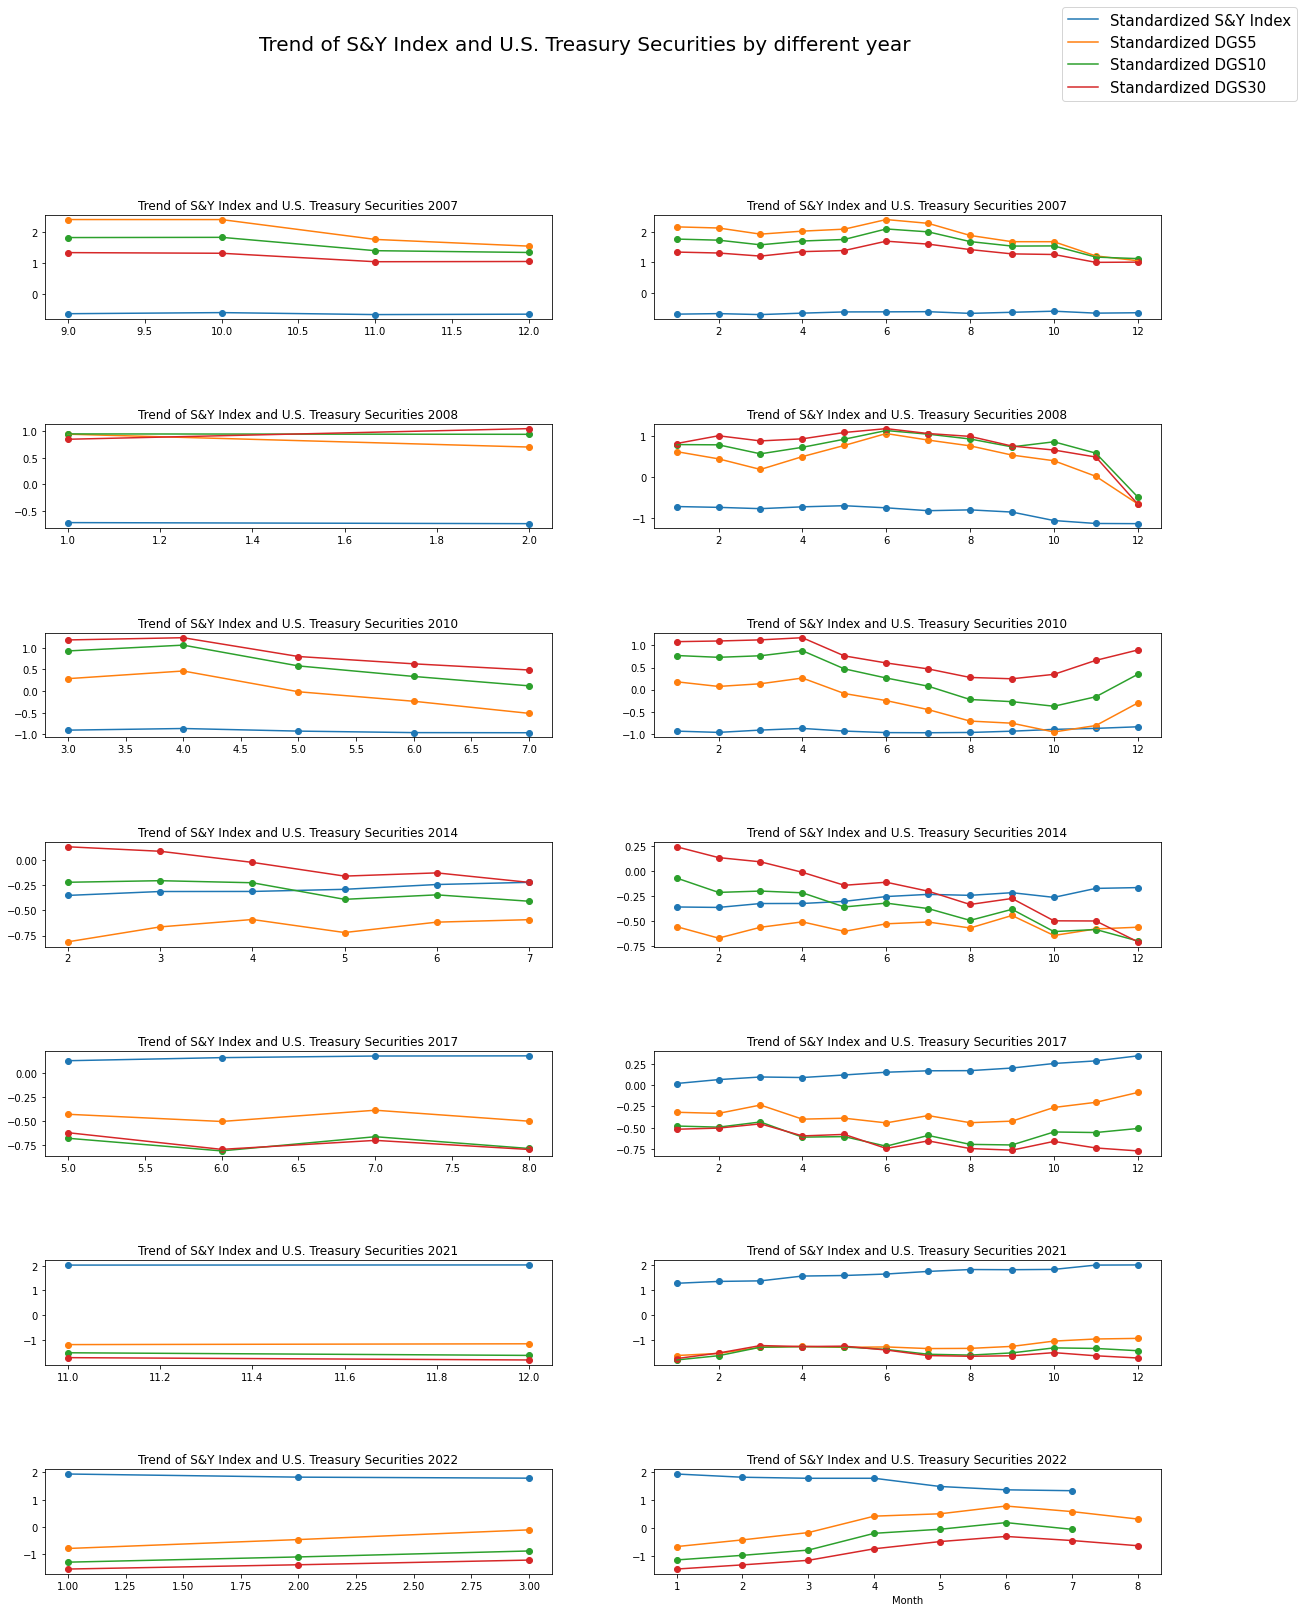

In [80]:
# plot the bull market and compare it with the same year's standardized data in June-August
query = [[2007, (9, 12)], [2008, (1, 2)], [2010, (3, 7)], [2014, (2, 7)], [2017, (5, 8)], \
         [2021, (11, 12)], [2022, (1, 3)]]
compared = [[2007, (1, 12)], [2008, (1, 12)], [2010, (6, 8)], [2014, (6, 8)], [2017, (6, 8)],\
            [2021, (6, 8)], [2022, (6, 8)]]
dfs_compared = []
for j in compared:
    dfs_compared.append(merged_everydata[merged_everydata['Date'].apply(lambda x: x.year == j[0])])
target_compared = pd.concat(dfs_compared)
target_compared['Crude Oil(Thousand Barrels)_std'] = preprocessing.scale(target_compared['Crude Oil(Thousand Barrels)'])
target_compared['SPY Close Price_std'] = preprocessing.scale(target_compared['SPY Close Price'])
target_compared['Gold Price_std'] = preprocessing.scale(target_compared['Gold Price'])
target_compared['DGS5_std'] = preprocessing.scale(target_compared['DGS5'])
target_compared['DGS10_std'] = preprocessing.scale(target_compared['DGS10'])
target_compared['DGS20_std'] = preprocessing.scale(target_compared['DGS20'])
target_compared['DGS30_std'] = preprocessing.scale(target_compared['DGS30'])
target['Month'] = target['Date'].apply(lambda x: x.month)
target['Year'] = target['Date'].apply(lambda x: x.year)
target_compared['Month'] = target_compared['Date'].apply(lambda x: x.month)
target_compared['Year'] = target_compared['Date'].apply(lambda x: x.year)
groups = target.groupby(['Year', 'Month']).mean().reset_index().groupby('Year')
groups_compared = target_compared.groupby(['Year', 'Month']).mean().reset_index().groupby('Year')
fig = plt.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=1)
axes = fig.subplots(nrows=len(groups), ncols=2)
for i, df in enumerate(groups):
    ax = fig.axes[i * 2]
    ax.scatter(df[1]['Month'], df[1]['SPY Close Price_std'])
    ax.plot(df[1]['Month'], df[1]['SPY Close Price_std'])
    ax.scatter(df[1]['Month'], df[1]['DGS5_std'])
    ax.plot(df[1]['Month'], df[1]['DGS5_std'])
    ax.scatter(df[1]['Month'], df[1]['DGS10_std'])
    ax.plot(df[1]['Month'], df[1]['DGS10_std'])
    ax.scatter(df[1]['Month'], df[1]['DGS30_std'])
    ax.plot(df[1]['Month'], df[1]['DGS30_std'])
    ax.title.set_text(f'Trend of S&Y Index and U.S. Treasury Securities {df[0]}')
    plt.xlabel('Month')
    
    ax = fig.axes[i * 2 + 1]
    df_compared = groups_compared.get_group(list(groups_compared.groups.keys())[i])
    ax.scatter(df_compared['Month'], df_compared['SPY Close Price_std'])
    ax.plot(df_compared['Month'], df_compared['SPY Close Price_std'])
    ax.scatter(df_compared['Month'], df_compared['DGS5_std'])
    ax.plot(df_compared['Month'], df_compared['DGS5_std'])
    ax.scatter(df_compared['Month'], df_compared['DGS10_std'])
    ax.plot(df_compared['Month'], df_compared['DGS10_std'])
    ax.scatter(df_compared['Month'], df_compared['DGS30_std'])
    ax.plot(df_compared['Month'], df_compared['DGS30_std'])
    plt.xlabel('Month')
    ax.title.set_text(f'Trend of S&Y Index and U.S. Treasury Securities {df[0]}')
fig.legend(['Standardized S&Y Index', 'Standardized DGS5', 'Standardized DGS10', \
            'Standardized DGS30'], loc='upper right', prop={'size': 15})
fig.suptitle('Trend of S&Y Index and U.S. Treasury Securities by different year', size = 20)
plt.show()

### Investigate the relationship between Market Yield on Gold Price and Bull Market 

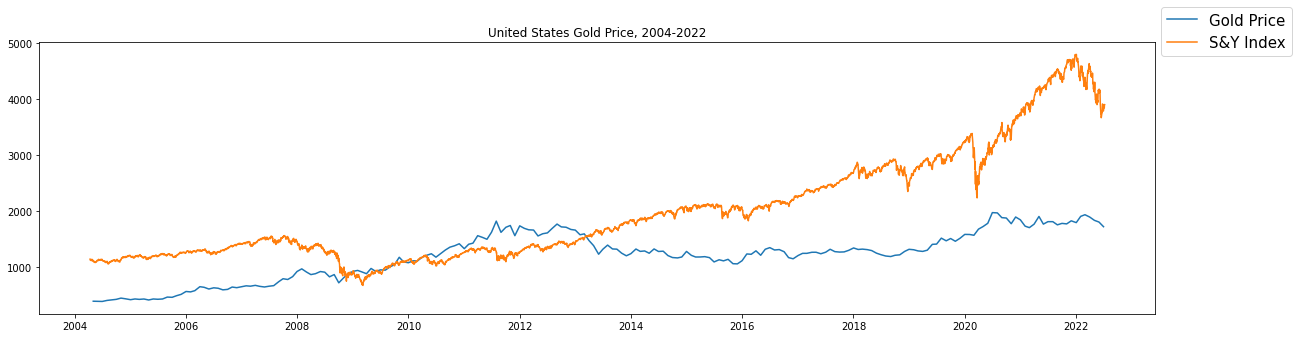

In [81]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(Gold_price2004['Date'], Gold_price2004['Gold Price'])
plt.plot(SPY['Date'], SPY['SPY Close Price'])
plt.title('United States Gold Price, 2004-2022')
f.legend(['Gold Price', 'S&Y Index'], loc='upper right', prop={'size': 15})
plt.show()


In [120]:
merged_everydata_2004 = merged_everydata[merged_everydata['Date'] >= SPY.iloc[-1]['Date']]
merged_everydata_2004 = merged_everydata_2004[merged_everydata_2004['Date'] <= SPY.iloc[0]['Date']].reset_index().drop(columns = 'index')
merged_everydata_2004['Year'] = merged_everydata_2004['Date'].apply(lambda x: x.year)
merged_everydata_2004['Month'] = merged_everydata_2004['Date'].apply(lambda y: y.month)
merged_everydata_2004['DGS5'] = merged_everydata_2004['DGS5'].astype('float')
merged_everydata_2004['DGS10'] = merged_everydata_2004['DGS10'].astype('float')
merged_everydata_2004['DGS20'] = merged_everydata_2004['DGS20'].astype('float')
merged_everydata_2004['DGS30'] = merged_everydata_2004['DGS30'].astype('float')
monthly_mean_2004 = merged_everydata_2004.groupby(['Year', 'Month']).agg('mean')
merged_everydata_2004['SPY Close Price_std'] = preprocessing.scale(merged_everydata_2004['SPY Close Price'])
merged_everydata_2004['Gold Price_std'] = preprocessing.scale(merged_everydata_2004['Gold Price'])

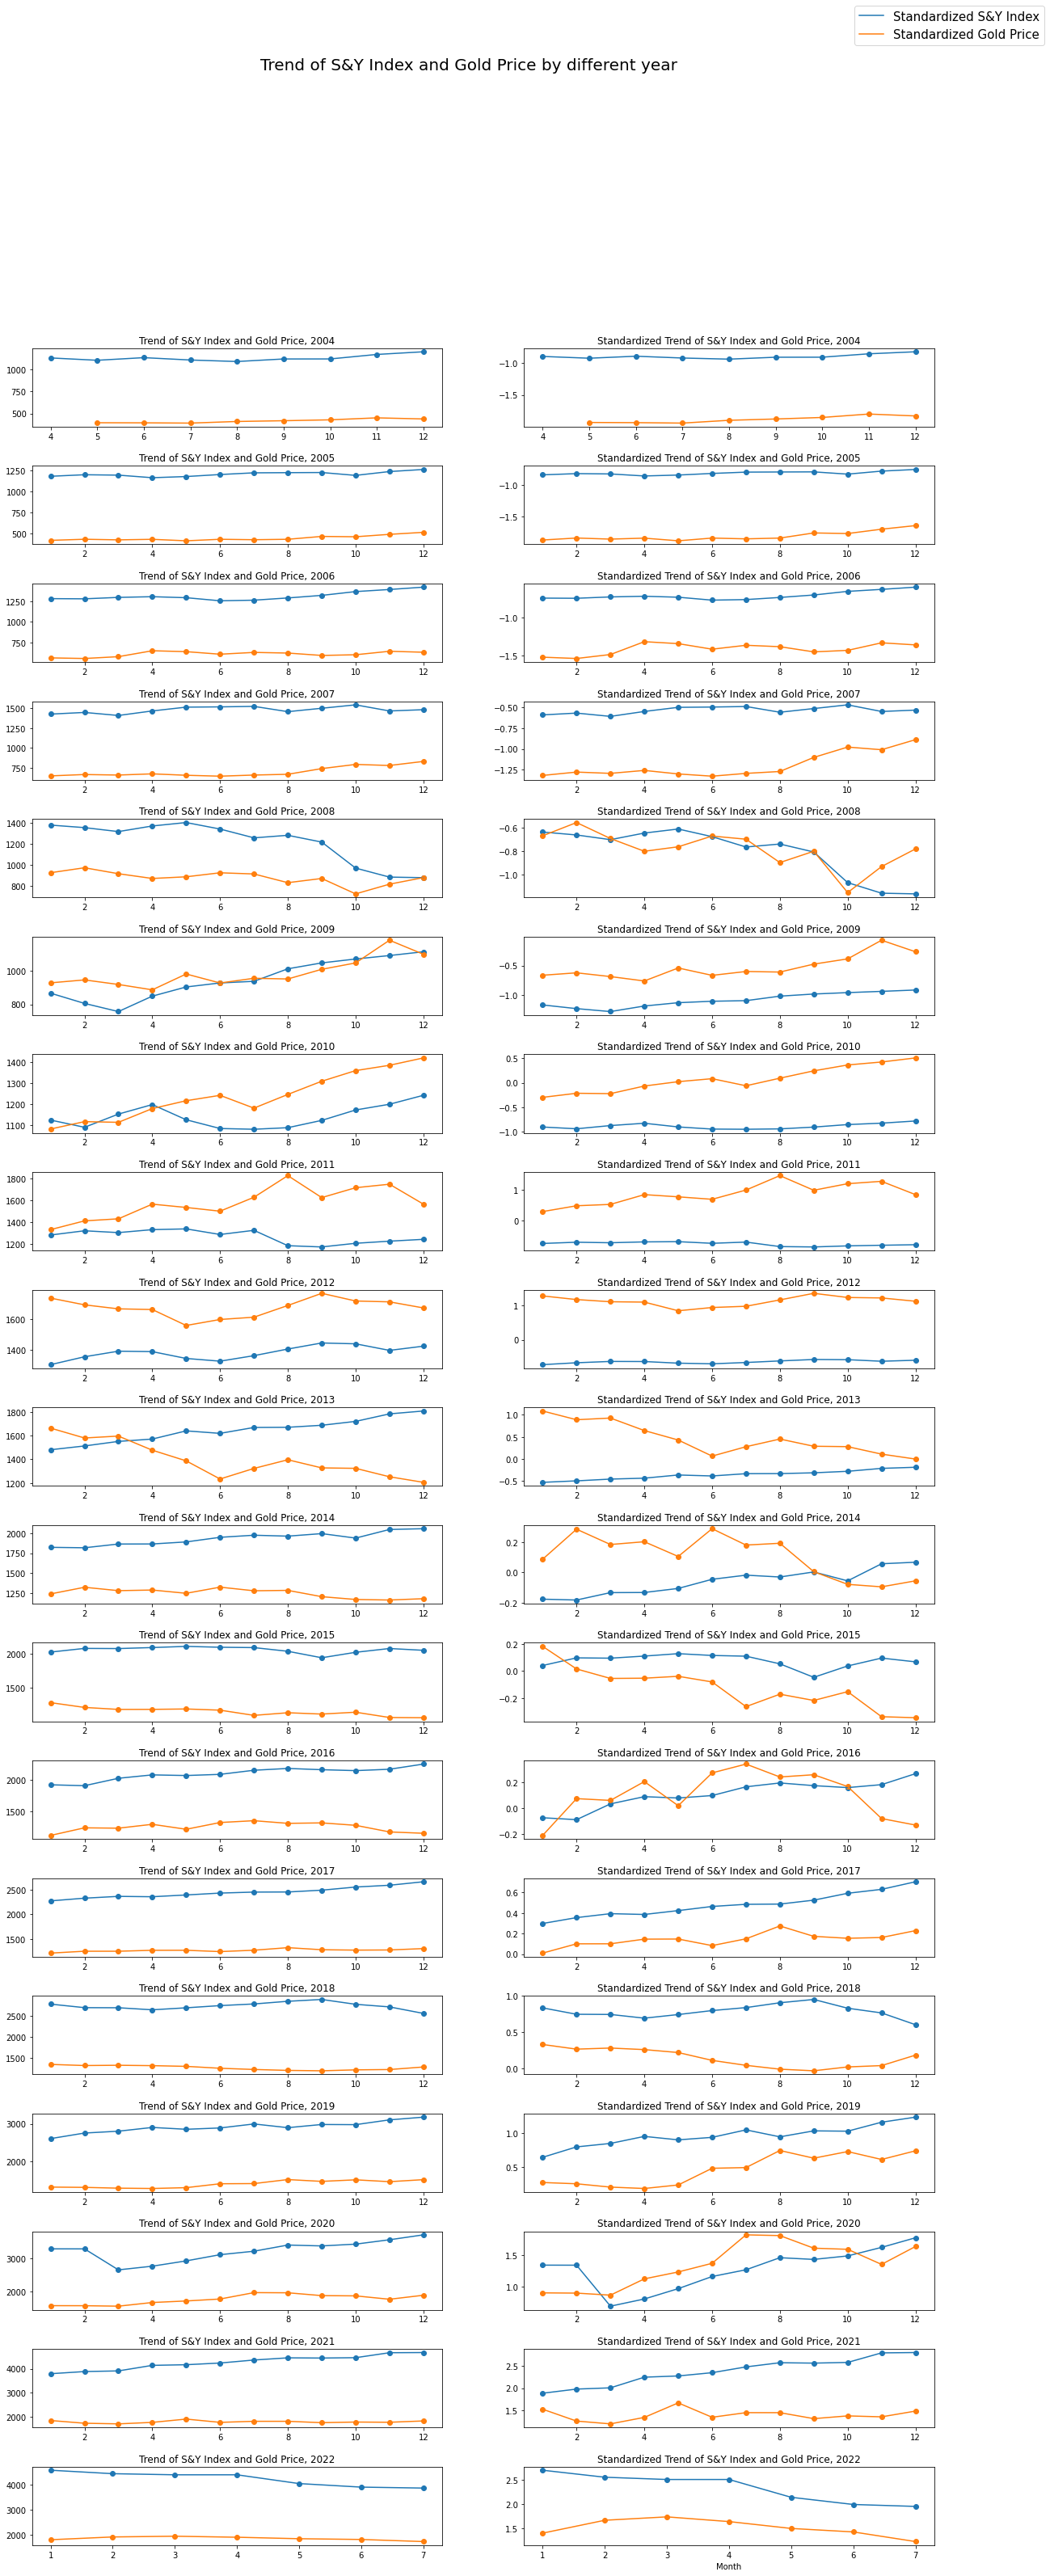

In [121]:
# plot the bull market and compare it with the same year's standardized data in June-August 
groups_compared = merged_everydata_2004.groupby(['Year', 'Month']).mean().reset_index().groupby('Year')
fig = plt.figure(figsize=(20, 50))
fig.subplots_adjust(hspace=0.5)
axes = fig.subplots(nrows=len(groups_compared), ncols=2)
for i, df in enumerate(groups_compared):
    ax = fig.axes[i * 2]
    df_compared = groups_compared.get_group(list(range(2004, 2023))[i])
    ax.scatter(df_compared['Month'], df_compared['SPY Close Price'])
    ax.plot(df_compared['Month'], df_compared['SPY Close Price'])
    ax.scatter(df_compared['Month'], df_compared['Gold Price'])
    ax.plot(df_compared['Month'], df_compared['Gold Price'])
    plt.xlabel('Month')
    ax.title.set_text(f'Trend of S&Y Index and Gold Price, {df[0]}')
    ax = fig.axes[i * 2 + 1]
    ax.scatter(df_compared['Month'], df_compared['SPY Close Price_std'])
    ax.plot(df_compared['Month'], df_compared['SPY Close Price_std'])
    ax.scatter(df_compared['Month'], df_compared['Gold Price_std'])
    ax.plot(df_compared['Month'], df_compared['Gold Price_std'])
    plt.xlabel('Month')
    ax.title.set_text(f'Standardized Trend of S&Y Index and Gold Price, {df[0]}')
fig.legend(['Standardized S&Y Index', 'Standardized Gold Price'], loc='upper right', prop={'size': 15})
fig.suptitle('Trend of S&Y Index and Gold Price by different year', size = 20)
plt.show()

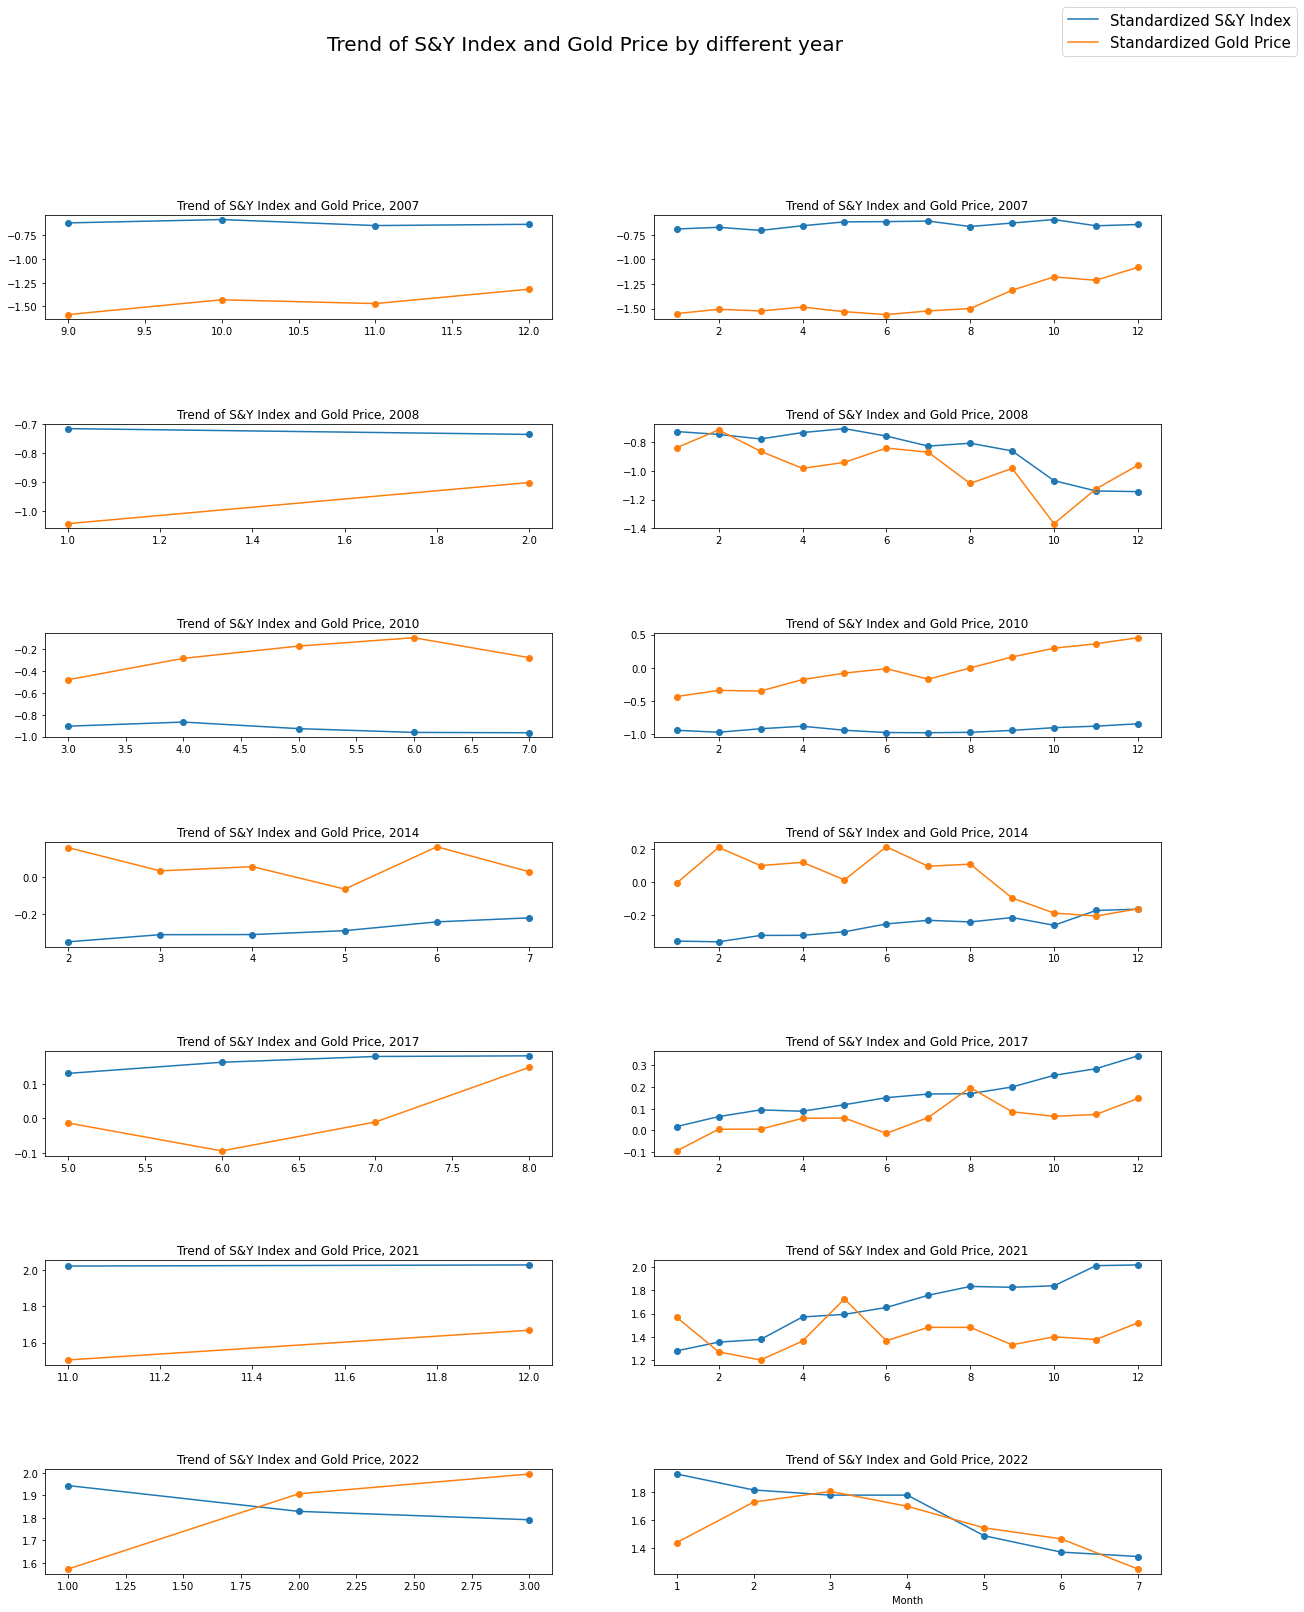

In [118]:
# plot the bull market and compare it with the same year's standardized data in June-August
query = [[2007, (9, 12)], [2008, (1, 2)], [2010, (3, 7)], [2014, (2, 7)], [2017, (5, 8)], \
         [2021, (11, 12)], [2022, (1, 3)]]
compared = [[2007, (1, 12)], [2008, (1, 12)], [2010, (6, 8)], [2014, (6, 8)], [2017, (6, 8)],\
            [2021, (6, 8)], [2022, (6, 8)]]
dfs_compared = []
for j in compared:
    dfs_compared.append(merged_everydata[merged_everydata['Date'].apply(lambda x: x.year == j[0])])
target_compared = pd.concat(dfs_compared)
target_compared['SPY Close Price_std'] = preprocessing.scale(target_compared['SPY Close Price'])
target_compared['Gold Price_std'] = preprocessing.scale(target_compared['Gold Price'])
target['Month'] = target['Date'].apply(lambda x: x.month)
target['Year'] = target['Date'].apply(lambda x: x.year)
target_compared['Month'] = target_compared['Date'].apply(lambda x: x.month)
target_compared['Year'] = target_compared['Date'].apply(lambda x: x.year)
groups = target.groupby(['Year', 'Month']).mean().reset_index().groupby('Year')
groups_compared = target_compared.groupby(['Year', 'Month']).mean().reset_index().groupby('Year')
fig = plt.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=1)
axes = fig.subplots(nrows=len(groups), ncols=2)
for i, df in enumerate(groups):
    ax = fig.axes[i * 2]
    ax.scatter(df[1]['Month'], df[1]['SPY Close Price_std'])
    ax.plot(df[1]['Month'], df[1]['SPY Close Price_std'])
    ax.scatter(df[1]['Month'], df[1]['Gold Price_std'])
    ax.plot(df[1]['Month'], df[1]['Gold Price_std'])
    ax.title.set_text(f'Trend of S&Y Index and Gold Price, {df[0]}')
    plt.xlabel('Month')
    
    ax = fig.axes[i * 2 + 1]
    df_compared = groups_compared.get_group(list(groups_compared.groups.keys())[i])
    ax.scatter(df_compared['Month'], df_compared['SPY Close Price_std'])
    ax.plot(df_compared['Month'], df_compared['SPY Close Price_std'])
    ax.scatter(df_compared['Month'], df_compared['Gold Price_std'])
    ax.plot(df_compared['Month'], df_compared['Gold Price_std'])
    plt.xlabel('Month')
    ax.title.set_text(f'Trend of S&Y Index and Gold Price, {df[0]}')
fig.legend(['Standardized S&Y Index', 'Standardized Gold Price'], loc='upper right', prop={'size': 15})
fig.suptitle('Trend of S&Y Index and Gold Price by different year', size = 20)
plt.show()

In general, we found that the S&Y Index has a reversing general trend with gold price. However, it is not that evident enough, so we further try to find the period when S&Y index and bond yield are all increasing or decreasing, and investigate the trend of gold price at that period.

In [83]:
monthly_mean_2004['DGS5 PercentChange(%)'] = monthly_mean_2004['DGS5'].pct_change(axis = 0).apply(lambda x: x * 100)
monthly_mean_2004['DGS10 PercentChange(%)'] = monthly_mean_2004['DGS10'].pct_change(axis = 0).apply(lambda x: x * 100)
monthly_mean_2004['DGS20 PercentChange(%)'] = monthly_mean_2004['DGS20'].pct_change(axis = 0).apply(lambda x: x * 100)
monthly_mean_2004['DGS30 PercentChange(%)'] = monthly_mean_2004['DGS30'].pct_change(axis = 0).apply(lambda x: x * 100)
monthly_mean_2004['SPY Close Price PercentChange(%)'] = monthly_mean_2004['SPY Close Price'].pct_change(axis = 0).apply(lambda x: x * 100)
monthly_mean_2004 = monthly_mean_2004.dropna()

In [84]:
increasing_month_year = list(monthly_mean_2004[(monthly_mean_2004['DGS5 PercentChange(%)'] > 0) & (monthly_mean_2004['SPY Close Price PercentChange(%)'] > 0)].index)

In [85]:
decreasing_month_year = list(monthly_mean_2004[(monthly_mean_2004['DGS5 PercentChange(%)'] < 0) & (monthly_mean_2004['SPY Close Price PercentChange(%)'] < 0)].index)

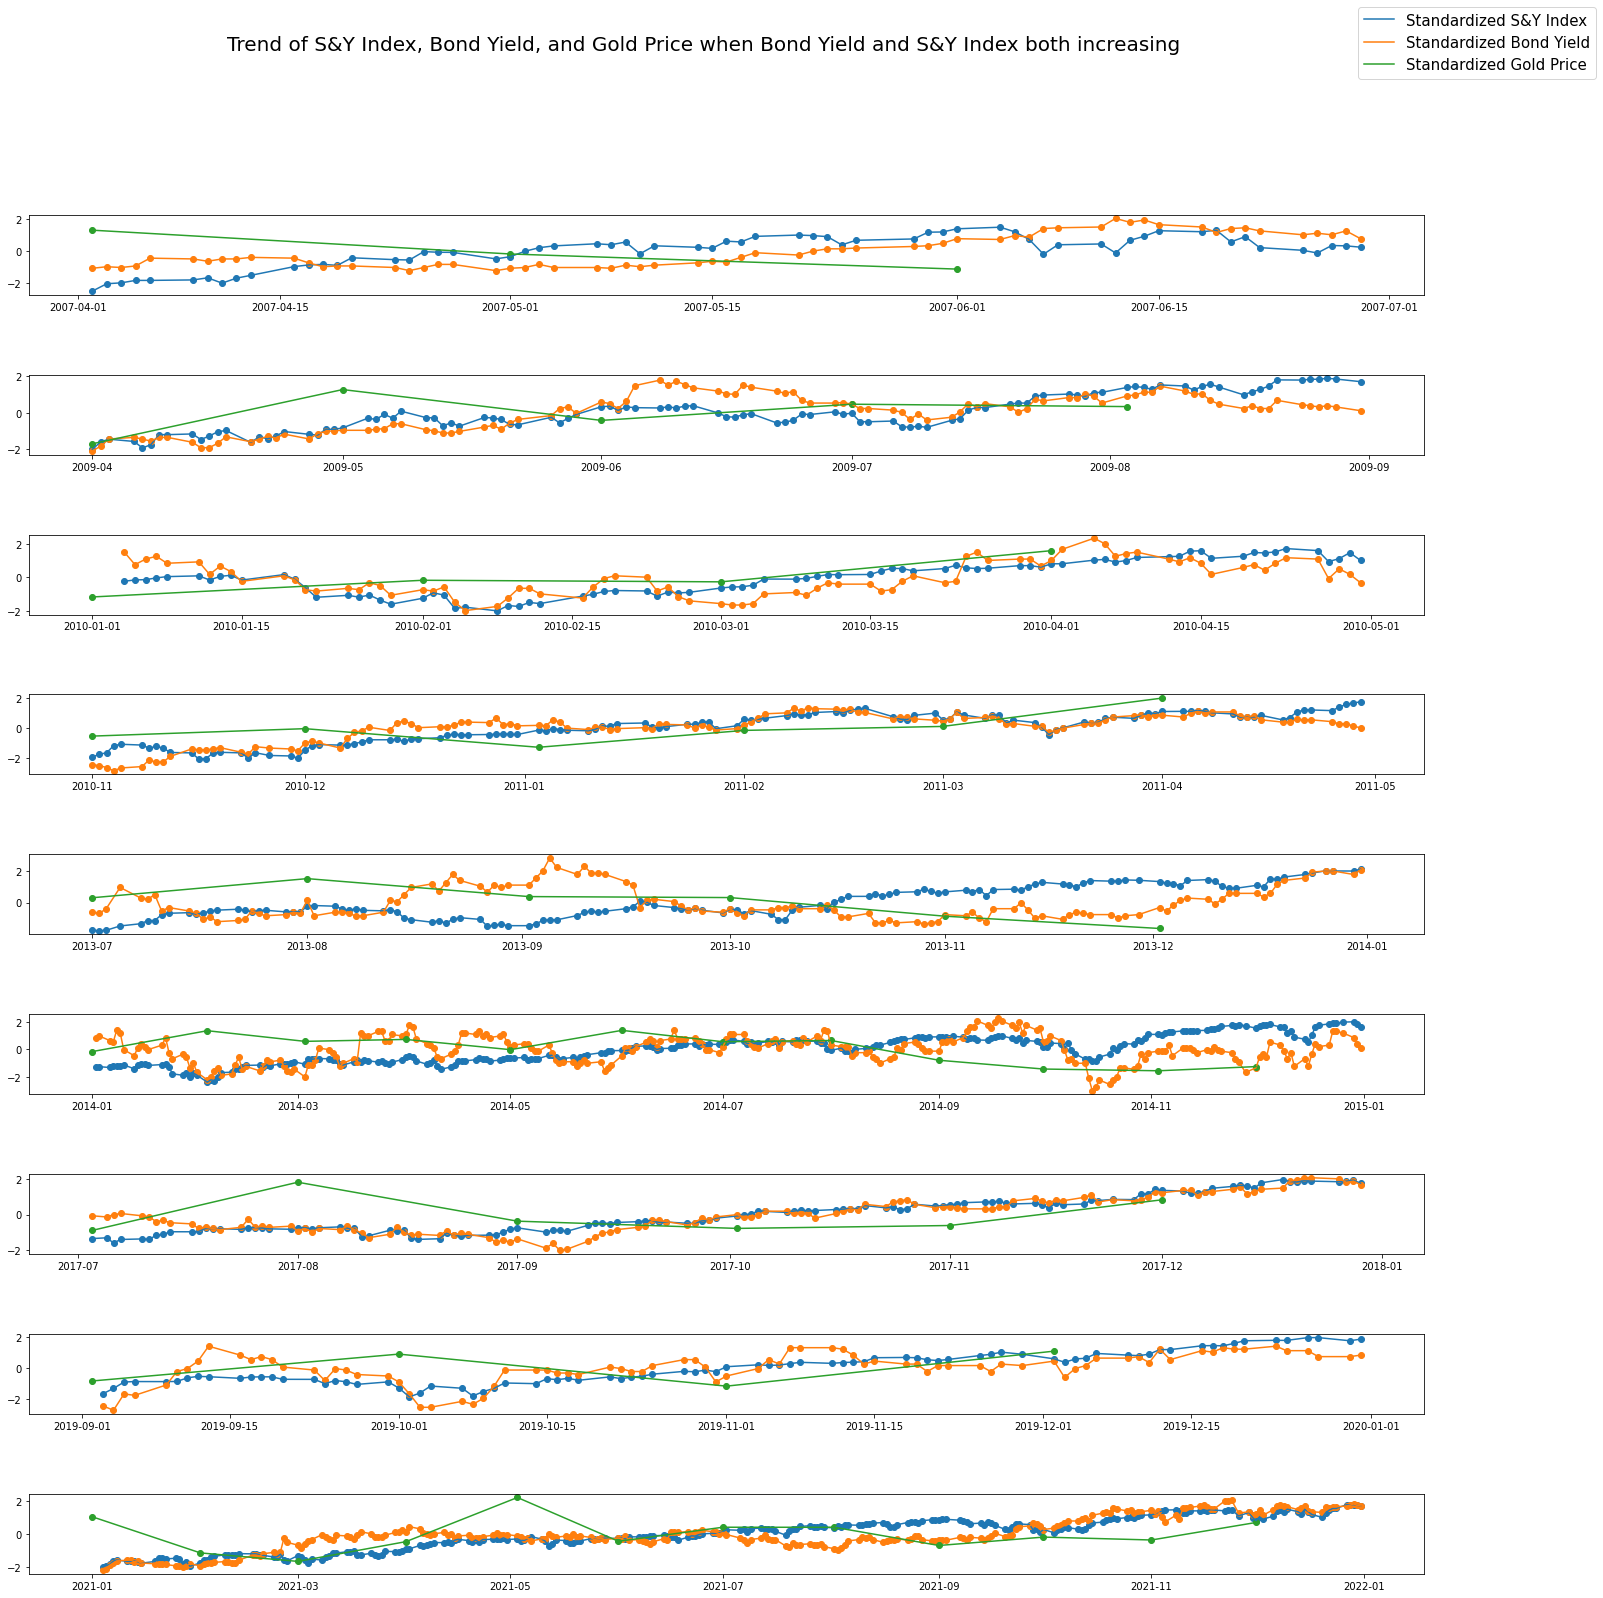

In [110]:
# plot the bull market and compare it with the same year's standardized data in June-August
query = [[2007, (4, 6)], [2009, (4, 8)], [2010, (1, 4)], [2010, (11, 12), 2011, (1, 4)], [2013, (7, 12)], \
         [2014, (1, 12)], [2017, (7, 12)], [2019, (9, 12)], [2021, (1, 12)]]
fig = plt.figure(figsize=(25, 25))
fig.subplots_adjust(hspace=1)
axes = fig.subplots(nrows=len(query), ncols=1)
for i, lst in enumerate(query):
    ax = fig.axes[i]
    if len(lst) > 2: 
        df = merged_everydata_2004[merged_everydata_2004['Date'].apply(lambda x: (x.year == lst[0] \
                                                               and (lst[1][0] <= x.month <= lst[1][1])) or (x.year == lst[2] and (lst[3][0] <= x.month <= lst[3][1])))]
        ax.scatter(df['Date'], preprocessing.scale(df['SPY Close Price'].ffill()))
        ax.plot(df['Date'], preprocessing.scale(df['SPY Close Price'].ffill()))
        ax.scatter(df['Date'], preprocessing.scale(df['DGS5'].ffill()))
        ax.plot(df['Date'], preprocessing.scale(df['DGS5'].ffill()))
        nonna_gold = df[~df['Gold Price'].isna()]
        ax.scatter(nonna_gold['Date'], preprocessing.scale(nonna_gold['Gold Price']))
        ax.plot(nonna_gold['Date'], preprocessing.scale(nonna_gold['Gold Price']))
    else:
        df = merged_everydata_2004[merged_everydata_2004['Date'].apply(lambda x: x.year == lst[0] \
                                                               and (lst[1][0] <= x.month <= lst[1][1]))]
        ax.scatter(df['Date'], preprocessing.scale(df['SPY Close Price'].ffill()))
        ax.plot(df['Date'], preprocessing.scale(df['SPY Close Price'].ffill()))        
        ax.scatter(df['Date'], preprocessing.scale(df['DGS5'].ffill()))
        ax.plot(df['Date'], preprocessing.scale(df['DGS5'].ffill()))     
        nonna_gold = df[~df['Gold Price'].isna()]
        ax.scatter(nonna_gold['Date'], preprocessing.scale(nonna_gold['Gold Price']))
        ax.plot(nonna_gold['Date'], preprocessing.scale(nonna_gold['Gold Price']))

fig.legend(['Standardized S&Y Index', 'Standardized Bond Yield', 'Standardized Gold Price'], loc='upper right', prop={'size': 15})
fig.suptitle('Trend of S&Y Index, Bond Yield, and Gold Price when Bond Yield and S&Y Index both increasing', size = 20)
plt.show()

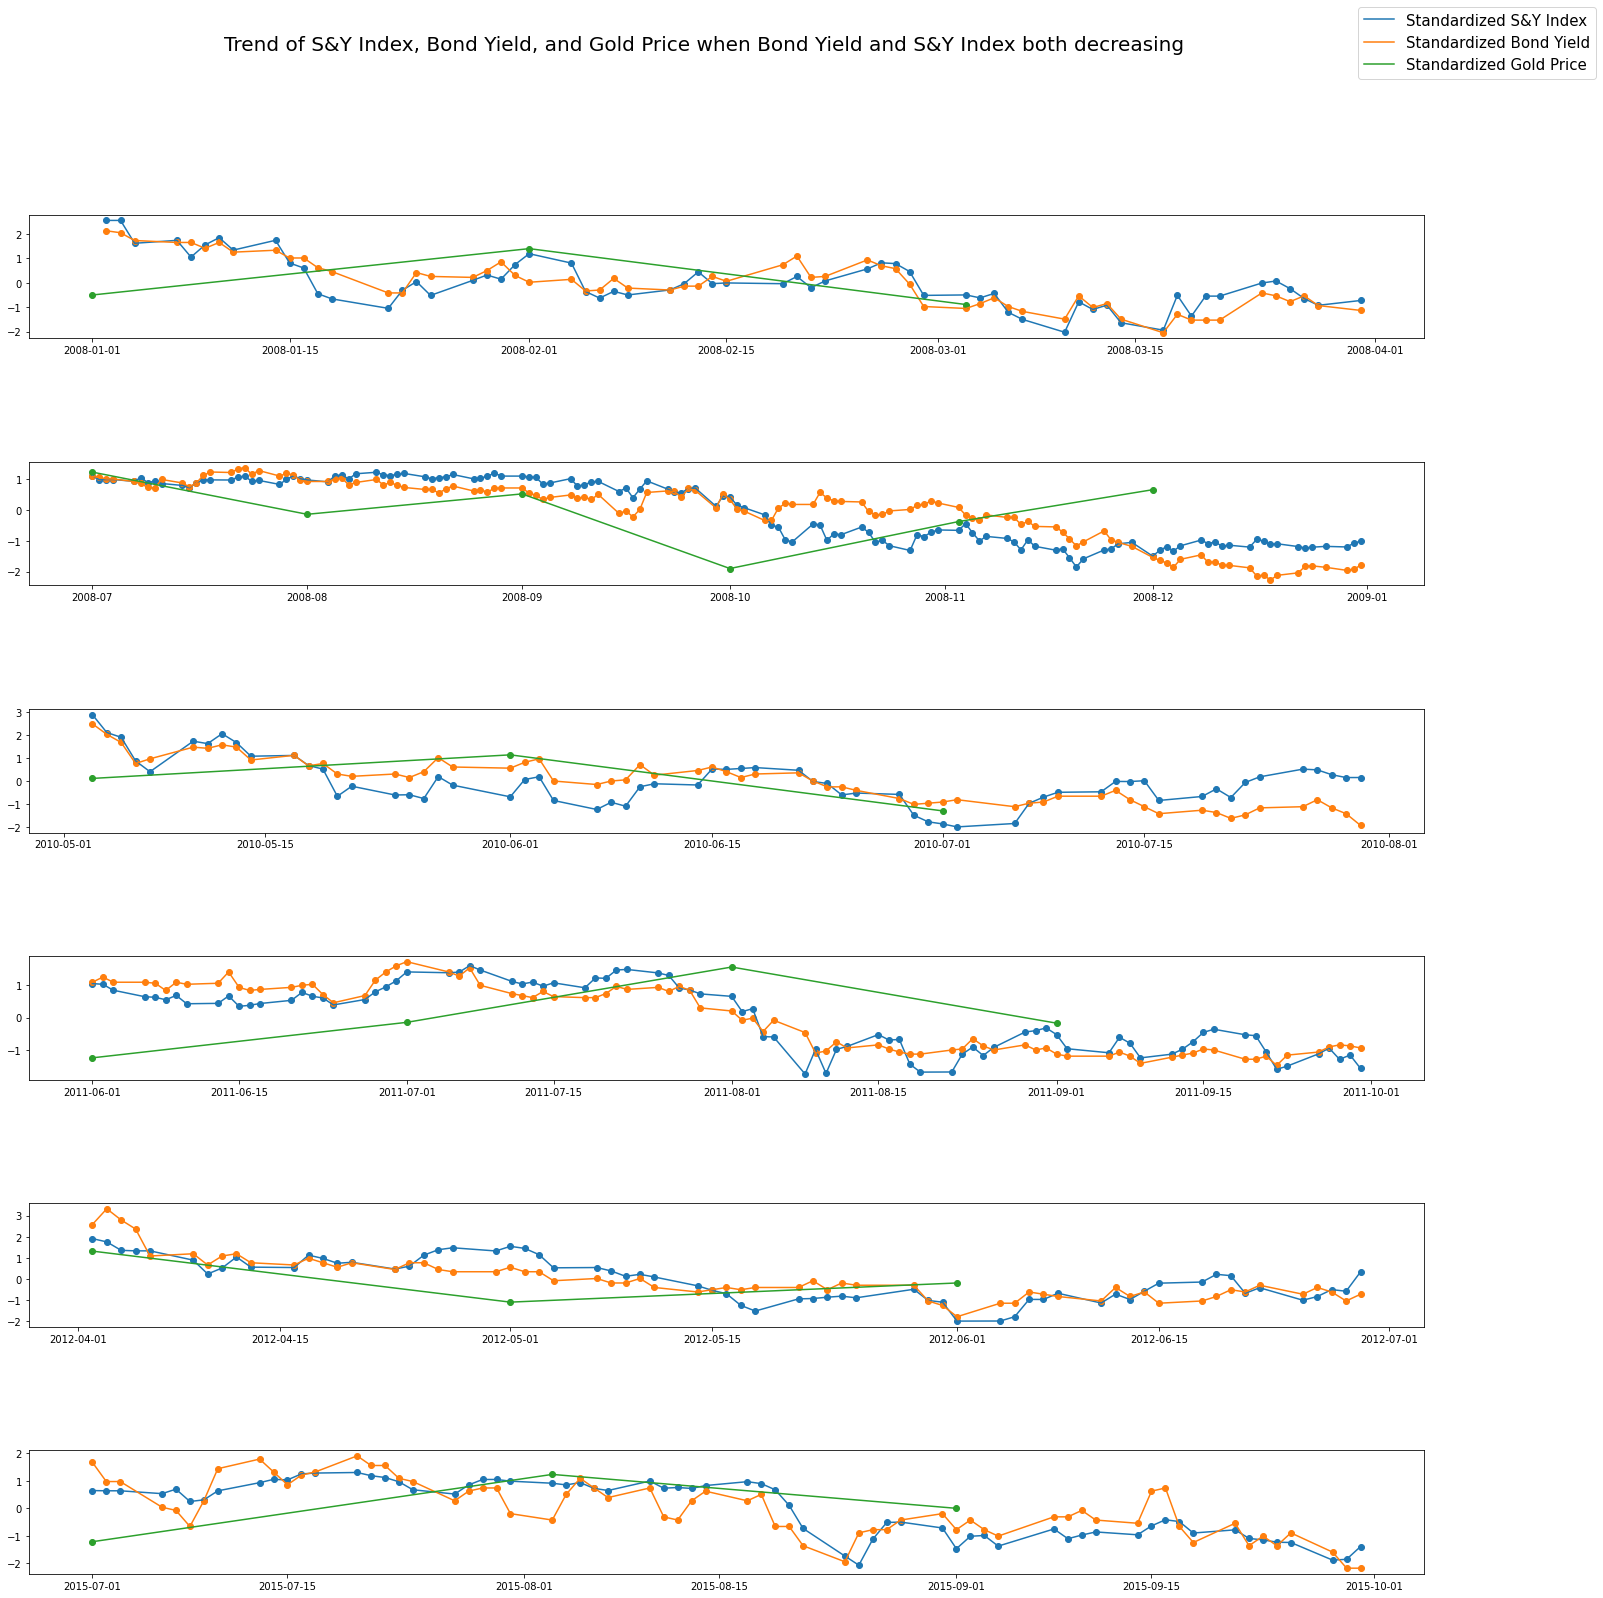

In [87]:
# plot the bull market and compare it with the same year's standardized data in June-August
query = [[2008, (1, 3)], [2008, (7, 12)], [2010, (5, 7)], [2011, (6, 9)], [2012, (4, 6)], \
         [2015, (7, 9)]]
fig = plt.figure(figsize=(25, 25))
fig.subplots_adjust(hspace=1)
axes = fig.subplots(nrows=len(query), ncols=1)
for i, lst in enumerate(query):
    ax = fig.axes[i]
    if len(lst) > 2: 
        df = merged_everydata_2004[merged_everydata_2004['Date'].apply(lambda x: (x.year == lst[0] \
                                                               and (lst[1][0] <= x.month <= lst[1][1])) or (x.year == lst[2] and (lst[3][0] <= x.month <= lst[3][1])))]
        ax.scatter(df['Date'], preprocessing.scale(df['SPY Close Price'].ffill()))
        ax.plot(df['Date'], preprocessing.scale(df['SPY Close Price'].ffill()))
        ax.scatter(df['Date'], preprocessing.scale(df['DGS5'].ffill()))
        ax.plot(df['Date'], preprocessing.scale(df['DGS5'].ffill()))
        nonna_gold = df[~df['Gold Price'].isna()]
        ax.scatter(nonna_gold['Date'], preprocessing.scale(nonna_gold['Gold Price']))
        ax.plot(nonna_gold['Date'], preprocessing.scale(nonna_gold['Gold Price']))
    else:
        df = merged_everydata_2004[merged_everydata_2004['Date'].apply(lambda x: x.year == lst[0] \
                                                               and (lst[1][0] <= x.month <= lst[1][1]))]
        ax.scatter(df['Date'], preprocessing.scale(df['SPY Close Price'].ffill()))
        ax.plot(df['Date'], preprocessing.scale(df['SPY Close Price'].ffill()))        
        ax.scatter(df['Date'], preprocessing.scale(df['DGS5'].ffill()))
        ax.plot(df['Date'], preprocessing.scale(df['DGS5'].ffill()))     
        nonna_gold = df[~df['Gold Price'].isna()]
        ax.scatter(nonna_gold['Date'], preprocessing.scale(nonna_gold['Gold Price']))
        ax.plot(nonna_gold['Date'], preprocessing.scale(nonna_gold['Gold Price']))

fig.legend(['Standardized S&Y Index', 'Standardized Bond Yield', 'Standardized Gold Price'], loc='upper right', prop={'size': 15})
fig.suptitle('Trend of S&Y Index, Bond Yield, and Gold Price when Bond Yield and S&Y Index both decreasing', size = 20)
plt.show()